In [113]:
import wandb
import numpy as np

In [115]:
api = wandb.Api()
import re
# Replace 'project_name' with your project's name
project_name = "project-kirby-examples_mlp_sweep"
project = api.project(project_name)
hp_dict = {}

sweeps = project.sweeps()
print(f"Found {len(sweeps)} sweeps.")
for sweep in sweeps:
    best = sweep.best_run()
    runs = api.runs(path=project_name, filters={"sweep": sweep.id})
    run_count = len(runs)
    if best:
        epochs = best.config.get('epochs', 'Not specified')
        val_acc = [row["val_accuracy"] for row in best.scan_history(keys=["val_accuracy"])]
        test_acc = [row["test_accuracy"] for row in best.scan_history(keys=["test_accuracy"])]

        val_acc.append(0)
        test_acc.append(0)
        # test accuracy is the corresponding test accuracy for the epoch with the best validation accuracy
        # so we will get both the max and argmax
        val_acc = max(val_acc)
        test_acc = max(test_acc)
        
        if (not sweep.name in hp_dict.keys()) or (sweep.name in hp_dict.keys() and val_acc > hp_dict[sweep.name]["val"]): #catch duplicate runs
            hp_dict[sweep.name] = {"val" : val_acc, "test" : test_acc, "session_id" : sweep.name}
            parts = best.name.split('/')
            for part in parts:
                if ":" in part:
                    hp, val = tuple(part.split(":"))
                    hp_dict[sweep.name][hp] = val
            hp_dict[sweep.name]["epochs"] = epochs
            try:
                hp_dict[sweep.name]["run count"] += run_count
            except:
                hp_dict[sweep.name]["run count"] = run_count

for each in hp_dict:
    print(hp_dict[each])

wandb: Sorting runs by -summary_metrics.val_accuracy


Found 478 sweeps.


wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_ac

{'val': 0, 'test': 0, 'session_id': '37115675', 'epochs': 'Not specified', 'run count': 100}
{'val': 0.24444444477558136, 'test': 0.1111111119389534, 'session_id': '657775947', 'sweep': "['657775947']", 'lr': '2.28e-03', 'b': '128', 'lyr': '[32, 16]', 'unit_drop': '0.31234328794567745', 'wt_drop': '0.12954738404788496', 'epochs': 100, 'run count': 100}
{'val': 0.8333333730697632, 'test': 0.7472222447395325, 'session_id': '653123929', 'sweep': "['653123929']", 'lr': '3.15e-03', 'b': '128', 'lyr': '[128, 128, 64, 32]', 'unit_drop': '0.01758293653312709', 'wt_drop': '0.26413946279529943', 'epochs': 100, 'run count': 100}
{'val': 0.7888889312744141, 'test': 0.6055555939674377, 'session_id': '564425777', 'sweep': "['564425777']", 'lr': '4.78e-04', 'b': '64', 'lyr': '[64, 32]', 'unit_drop': '0.463859227018195', 'wt_drop': '0.4105029219207545', 'epochs': 100, 'run count': 100}
{'val': 0.5333333611488342, 'test': 0.49722224473953247, 'session_id': '510390912', 'sweep': "['510390912']", 'lr': '

In [152]:
api = wandb.Api()
import re
# Replace 'project_name' with your project's name
project_name = "project-kirby-examples_mlp_sweep"
project = api.project(project_name)
sweeps = project.sweeps()
print(f"Found {len(sweeps)} sweeps.")

Found 479 sweeps.


<bound method Run.history of <Run neuro-galaxy/project-kirby-examples_mlp_sweep/161f2m35 (finished)>>

In [180]:
from tqdm import tqdm

def process_run(run):
    if not 'dataset' in run.config:
        return dict(failed=True)
    session_id = run.config['dataset'][0]['selection'][0]['sortsets'][0]
    val_acc = [row["val_accuracy"] for row in run.scan_history(keys=["val_accuracy"])]
    test_acc = [row["test_accuracy"] for row in run.scan_history(keys=["test_accuracy"])]
    failed = len(test_acc) == 0
    if failed:
        val_acc = None
        test_acc = None
    else:
        val_acc = max(val_acc)
        assert len(test_acc) == 1
        test_acc = test_acc[0]
    return dict(session_id=session_id, val_acc=val_acc, test_acc=test_acc, failed=failed)

def process_sweep(sweep):
    runs = api.runs(path=project_name, filters={"sweep": sweep.id})
    
    run_count = 0
    best_val_acc = 0
    best_test_acc = 0
    session_id = None
    for run in tqdm(runs):
        out = process_run(run)
        if out['failed']:
            continue
        run_count += 1
        if out['val_acc'] > best_val_acc:
            best_val_acc = out['val_acc']
            best_test_acc = out['test_acc']
        if session_id is None:
            session_id = out['session_id']
        else:
            assert session_id == out['session_id']

    return dict(session_id=session_id, run_count=run_count, best_val_acc=best_val_acc, best_test_acc=best_test_acc)


In [181]:
api = wandb.Api()

project_name = "project-kirby-examples_mlp_sweep"
project = api.project(project_name)
sweeps = project.sweeps()
print(f"Found {len(sweeps)} sweeps.")

out = []
for sweep in sweeps:
    result = process_sweep(sweep)
    print(result)
    out.append(result)

Found 479 sweeps.


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


{'session_id': '649409874', 'run_count': 17, 'best_val_acc': 0.23444975912570953, 'best_test_acc': 0.13768115639686584}


100%|██████████| 100/100 [00:00<00:00, 427.77it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


{'session_id': '657775947', 'run_count': 100, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.1111111119389534}


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


{'session_id': '653123929', 'run_count': 100, 'best_val_acc': 0.8500000238418579, 'best_test_acc': 0.7611111402511597}


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


{'session_id': '564425777', 'run_count': 100, 'best_val_acc': 0.8111111521720886, 'best_test_acc': 0.5861111283302307}


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


{'session_id': '510390912', 'run_count': 100, 'best_val_acc': 0.5333333611488342, 'best_test_acc': 0.49722224473953247}


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


{'session_id': '649324898', 'run_count': 100, 'best_val_acc': 0.23333333432674408, 'best_test_acc': 0.16111111640930176}


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


{'session_id': '565216523', 'run_count': 100, 'best_val_acc': 0.699999988079071, 'best_test_acc': 0.5069251656532288}


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


{'session_id': '676024666', 'run_count': 100, 'best_val_acc': 0.27222222089767456, 'best_test_acc': 0.09972298890352249}


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


{'session_id': '571006300', 'run_count': 100, 'best_val_acc': 0.5444444417953491, 'best_test_acc': 0.38055557012557983}


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


{'session_id': '588483711', 'run_count': 100, 'best_val_acc': 0.6243094205856323, 'best_test_acc': 0.5955678224563599}


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


{'session_id': '551888519', 'run_count': 100, 'best_val_acc': 0.4555555582046509, 'best_test_acc': 0.2845304012298584}


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


{'session_id': '575302108', 'run_count': 100, 'best_val_acc': 0.5277777910232544, 'best_test_acc': 0.3361111283302307}


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


{'session_id': '567878987', 'run_count': 100, 'best_val_acc': 0.2888889014720917, 'best_test_acc': 0.14722222089767456}


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


{'session_id': '506773185', 'run_count': 100, 'best_val_acc': 0.5388889312744141, 'best_test_acc': 0.3861111104488373}


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


{'session_id': '570008444', 'run_count': 100, 'best_val_acc': 0.3333333432674408, 'best_test_acc': 0.2936288118362427}


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


{'session_id': '685816006', 'run_count': 100, 'best_val_acc': 0.4166666865348816, 'best_test_acc': 0.31111112236976624}


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


{'session_id': '605800963', 'run_count': 100, 'best_val_acc': 0.3222222328186035, 'best_test_acc': 0.25207754969596863}


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


{'session_id': '682049099', 'run_count': 100, 'best_val_acc': 0.41111111640930176, 'best_test_acc': 0.23333333432674408}


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


{'session_id': '573261515', 'run_count': 100, 'best_val_acc': 0.7666667103767395, 'best_test_acc': 0.6722222566604614}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '652989442', 'run_count': 100, 'best_val_acc': 0.21111111342906952, 'best_test_acc': 0.13611111044883728}


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


{'session_id': '583136567', 'run_count': 100, 'best_val_acc': 0.5898617506027222, 'best_test_acc': 0.5132530331611633}


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


{'session_id': '501929610', 'run_count': 100, 'best_val_acc': 0.694444477558136, 'best_test_acc': 0.6565096974372864}


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


{'session_id': '673171528', 'run_count': 100, 'best_val_acc': 0.2511848509311676, 'best_test_acc': 0.09927361458539963}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '662974315', 'run_count': 100, 'best_val_acc': 0.6277778148651123, 'best_test_acc': 0.6027777791023254}


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


{'session_id': '502376461', 'run_count': 100, 'best_val_acc': 0.591160237789154, 'best_test_acc': 0.4888888895511627}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '507990552', 'run_count': 100, 'best_val_acc': 0.6961326003074646, 'best_test_acc': 0.5805555582046509}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '576001843', 'run_count': 100, 'best_val_acc': 0.6666666865348816, 'best_test_acc': 0.6620498299598694}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '617381605', 'run_count': 100, 'best_val_acc': 0.7888889312744141, 'best_test_acc': 0.7750000357627869}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '510093797', 'run_count': 100, 'best_val_acc': 0.5888888835906982, 'best_test_acc': 0.38055557012557983}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '524691284', 'run_count': 100, 'best_val_acc': 0.9000000357627869, 'best_test_acc': 0.8666666746139526}


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


{'session_id': '605606109', 'run_count': 100, 'best_val_acc': 0.42222222685813904, 'best_test_acc': 0.27624309062957764}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '601904502', 'run_count': 100, 'best_val_acc': 0.32777777314186096, 'best_test_acc': 0.18888889253139496}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '617388117', 'run_count': 100, 'best_val_acc': 0.25, 'best_test_acc': 0.09166666865348816}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '505695962', 'run_count': 100, 'best_val_acc': 0.694444477558136, 'best_test_acc': 0.6055555939674377}


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


{'session_id': '559192380', 'run_count': 100, 'best_val_acc': 0.41747573018074036, 'best_test_acc': 0.35784316062927246}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '591430494', 'run_count': 100, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.15833333134651184}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '569739027', 'run_count': 100, 'best_val_acc': 0.6000000238418579, 'best_test_acc': 0.4166666865348816}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '672207947', 'run_count': 100, 'best_val_acc': 0.8166666626930237, 'best_test_acc': 0.699999988079071}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '584544569', 'run_count': 100, 'best_val_acc': 0.28333333134651184, 'best_test_acc': 0.16944444179534912}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '712178511', 'run_count': 100, 'best_val_acc': 0.550000011920929, 'best_test_acc': 0.46388891339302063}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '649938038', 'run_count': 100, 'best_val_acc': 0.39444446563720703, 'best_test_acc': 0.347222238779068}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '657080632', 'run_count': 100, 'best_val_acc': 0.7611111402511597, 'best_test_acc': 0.7416666746139526}


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


{'session_id': '501574836', 'run_count': 100, 'best_val_acc': 0.8555555939674377, 'best_test_acc': 0.8361111283302307}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '686909240', 'run_count': 100, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.0914127379655838}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '561472633', 'run_count': 100, 'best_val_acc': 0.7666667103767395, 'best_test_acc': 0.7651934027671814}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '510514474', 'run_count': 100, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.6232686638832092}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '576095926', 'run_count': 100, 'best_val_acc': 0.6500000357627869, 'best_test_acc': 0.5916666984558105}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '508356957', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.4321329593658447}


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


{'session_id': '571684733', 'run_count': 100, 'best_val_acc': 0.4917127192020416, 'best_test_acc': 0.3573407232761383}


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


{'session_id': '698260532', 'run_count': 100, 'best_val_acc': 0.31904762983322144, 'best_test_acc': 0.23076923191547394}


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


{'session_id': '555042467', 'run_count': 100, 'best_val_acc': 0.41111111640930176, 'best_test_acc': 0.29722222685813904}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '595806300', 'run_count': 100, 'best_val_acc': 0.694444477558136, 'best_test_acc': 0.5250000357627869}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '570236381', 'run_count': 100, 'best_val_acc': 0.4444444477558136, 'best_test_acc': 0.3361111283302307}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '617395455', 'run_count': 100, 'best_val_acc': 0.25, 'best_test_acc': 0.10833333432674408}


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


{'session_id': '503324629', 'run_count': 100, 'best_val_acc': 0.644444465637207, 'best_test_acc': 0.5305555462837219}


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


{'session_id': '683257169', 'run_count': 100, 'best_val_acc': 0.8500000238418579, 'best_test_acc': 0.7666667103767395}


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


{'session_id': '501876401', 'run_count': 100, 'best_val_acc': 0.6611111164093018, 'best_test_acc': 0.6408839821815491}


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


{'session_id': '637154333', 'run_count': 100, 'best_val_acc': 0.21393033862113953, 'best_test_acc': 0.1182033121585846}


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


{'session_id': '603224878', 'run_count': 100, 'best_val_acc': 0.2944444417953491, 'best_test_acc': 0.18888889253139496}


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


{'session_id': '507691036', 'run_count': 100, 'best_val_acc': 0.45303869247436523, 'best_test_acc': 0.2611111104488373}


100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


{'session_id': '541010698', 'run_count': 100, 'best_val_acc': 0.5777778029441833, 'best_test_acc': 0.541436493396759}


100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


{'session_id': '541290571', 'run_count': 100, 'best_val_acc': 0.39444446563720703, 'best_test_acc': 0.3232044279575348}


100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


{'session_id': '680150733', 'run_count': 100, 'best_val_acc': 0.27222222089767456, 'best_test_acc': 0.17499999701976776}


100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


{'session_id': '580095655', 'run_count': 100, 'best_val_acc': 0.7900552749633789, 'best_test_acc': 0.7055555582046509}


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


{'session_id': '658854537', 'run_count': 100, 'best_val_acc': 0.6611111164093018, 'best_test_acc': 0.5638889074325562}


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


{'session_id': '603978471', 'run_count': 100, 'best_val_acc': 0.22651934623718262, 'best_test_acc': 0.0555555559694767}


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


{'session_id': '679702884', 'run_count': 100, 'best_val_acc': 0.7555555701255798, 'best_test_acc': 0.75}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '637669270', 'run_count': 100, 'best_val_acc': 0.7777777910232544, 'best_test_acc': 0.6814404129981995}


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


{'session_id': '588655112', 'run_count': 100, 'best_val_acc': 0.23076924681663513, 'best_test_acc': 0.16867470741271973}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '511573879', 'run_count': 100, 'best_val_acc': 0.6888889074325562, 'best_test_acc': 0.6666666865348816}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '599320182', 'run_count': 100, 'best_val_acc': 0.24861879646778107, 'best_test_acc': 0.1689750701189041}


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


{'session_id': '670395999', 'run_count': 100, 'best_val_acc': 0.23333333432674408, 'best_test_acc': 0.11080332100391388}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '551834174', 'run_count': 100, 'best_val_acc': 0.42222222685813904, 'best_test_acc': 0.24722222983837128}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '665722301', 'run_count': 100, 'best_val_acc': 0.21666666865348816, 'best_test_acc': 0.17777778208255768}


100%|██████████| 100/100 [00:57<00:00,  1.72it/s]


{'session_id': '563710064', 'run_count': 100, 'best_val_acc': 0.5777778029441833, 'best_test_acc': 0.4888888895511627}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '609517556', 'run_count': 100, 'best_val_acc': 0.23888888955116272, 'best_test_acc': 0.15235456824302673}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '611638995', 'run_count': 100, 'best_val_acc': 0.4055555760860443, 'best_test_acc': 0.2888889014720917}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '508563988', 'run_count': 100, 'best_val_acc': 0.43888890743255615, 'best_test_acc': 0.3638888895511627}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '580095655', 'run_count': 75, 'best_val_acc': 0.7734807133674622, 'best_test_acc': 0.7305555939674377}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '509958730', 'run_count': 100, 'best_val_acc': 0.9333333373069763, 'best_test_acc': 0.8342542052268982}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '560866155', 'run_count': 100, 'best_val_acc': 0.23888888955116272, 'best_test_acc': 0.11388888955116272}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '660064796', 'run_count': 100, 'best_val_acc': 0.30000001192092896, 'best_test_acc': 0.15512464940547943}


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


{'session_id': '584983136', 'run_count': 100, 'best_val_acc': 0.5055555701255798, 'best_test_acc': 0.49030470848083496}


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


{'session_id': '682051855', 'run_count': 100, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.6333333253860474}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '582867147', 'run_count': 100, 'best_val_acc': 0.46666666865348816, 'best_test_acc': 0.46388891339302063}


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


{'session_id': '598564173', 'run_count': 100, 'best_val_acc': 0.4611111283302307, 'best_test_acc': 0.3222222328186035}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '566096665', 'run_count': 100, 'best_val_acc': 0.4444444477558136, 'best_test_acc': 0.32500001788139343}


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


{'session_id': '603592541', 'run_count': 100, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.13333334028720856}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '623587006', 'run_count': 100, 'best_val_acc': 0.75, 'best_test_acc': 0.6759002804756165}


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


{'session_id': '581026088', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.42500001192092896}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '683253712', 'run_count': 100, 'best_val_acc': 0.37222224473953247, 'best_test_acc': 0.19722223281860352}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '653122667', 'run_count': 100, 'best_val_acc': 0.7111111283302307, 'best_test_acc': 0.7638888955116272}


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


{'session_id': '591548033', 'run_count': 100, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.17222222685813904}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '576411246', 'run_count': 100, 'best_val_acc': 0.2611111104488373, 'best_test_acc': 0.20000000298023224}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '637998955', 'run_count': 100, 'best_val_acc': 0.7055555582046509, 'best_test_acc': 0.6194444298744202}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '577665023', 'run_count': 100, 'best_val_acc': 0.2596685290336609, 'best_test_acc': 0.15555556118488312}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '699155265', 'run_count': 100, 'best_val_acc': 0.5333333611488342, 'best_test_acc': 0.48055556416511536}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '585900296', 'run_count': 100, 'best_val_acc': 0.20994475483894348, 'best_test_acc': 0.13055555522441864}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '572606382', 'run_count': 100, 'best_val_acc': 0.5111111402511597, 'best_test_acc': 0.38950276374816895}


100%|██████████| 100/100 [01:19<00:00,  1.27it/s]


{'session_id': '557225279', 'run_count': 100, 'best_val_acc': 0.6666666269302368, 'best_test_acc': 0.5485436916351318}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '582838758', 'run_count': 100, 'best_val_acc': 0.1944444477558136, 'best_test_acc': 0.15833333134651184}


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


{'session_id': '587339481', 'run_count': 100, 'best_val_acc': 0.6731707453727722, 'best_test_acc': 0.4771084487438202}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '562122508', 'run_count': 100, 'best_val_acc': 0.5722222328186035, 'best_test_acc': 0.45000001788139343}


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


{'session_id': '650079244', 'run_count': 100, 'best_val_acc': 0.21666666865348816, 'best_test_acc': 0.11666666716337204}


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


{'session_id': '658020691', 'run_count': 100, 'best_val_acc': 0.22777777910232544, 'best_test_acc': 0.11944444477558136}


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


{'session_id': '557227804', 'run_count': 100, 'best_val_acc': 0.28176796436309814, 'best_test_acc': 0.16343489289283752}


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


{'session_id': '592348507', 'run_count': 100, 'best_val_acc': 0.3499999940395355, 'best_test_acc': 0.1944444477558136}


100%|██████████| 25/25 [00:00<00:00, 114099.67it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 25/25 [00:00<00:00, 397187.88it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


{'session_id': '658533763', 'run_count': 100, 'best_val_acc': 0.25247523188591003, 'best_test_acc': 0.15479114651679993}


100%|██████████| 92/92 [00:47<00:00,  1.94it/s]


{'session_id': '650079244', 'run_count': 67, 'best_val_acc': 0.22777777910232544, 'best_test_acc': 0.12222222238779068}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '559382012', 'run_count': 100, 'best_val_acc': 0.3333333432674408, 'best_test_acc': 0.16111111640930176}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '676503588', 'run_count': 100, 'best_val_acc': 0.30000001192092896, 'best_test_acc': 0.17777778208255768}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '661328410', 'run_count': 100, 'best_val_acc': 0.5666666626930237, 'best_test_acc': 0.4792243540287018}


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


{'session_id': '672206735', 'run_count': 100, 'best_val_acc': 0.23333333432674408, 'best_test_acc': 0.1689750701189041}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '603425659', 'run_count': 100, 'best_val_acc': 0.550000011920929, 'best_test_acc': 0.3711911141872406}


100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '596779487', 'run_count': 100, 'best_val_acc': 0.4888888895511627, 'best_test_acc': 0.4027777910232544}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '651770380', 'run_count': 100, 'best_val_acc': 0.28176796436309814, 'best_test_acc': 0.13055555522441864}


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


{'session_id': '598137246', 'run_count': 100, 'best_val_acc': 0.2928176820278168, 'best_test_acc': 0.1689750701189041}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '647595665', 'run_count': 100, 'best_val_acc': 0.7055555582046509, 'best_test_acc': 0.6426592469215393}


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


{'session_id': '658518486', 'run_count': 100, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.13611111044883728}


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


{'session_id': '667004159', 'run_count': 100, 'best_val_acc': 0.6333333253860474, 'best_test_acc': 0.6111111044883728}


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


{'session_id': '555749369', 'run_count': 100, 'best_val_acc': 0.2222222238779068, 'best_test_acc': 0.13055555522441864}


100%|██████████| 46/46 [00:24<00:00,  1.91it/s]


{'session_id': '555749369', 'run_count': 21, 'best_val_acc': 0.21666666865348816, 'best_test_acc': 0.1388888955116272}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '595808594', 'run_count': 100, 'best_val_acc': 0.3922652006149292, 'best_test_acc': 0.2750000059604645}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '644386884', 'run_count': 100, 'best_val_acc': 0.31111112236976624, 'best_test_acc': 0.14166666567325592}


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


{'session_id': '646016204', 'run_count': 100, 'best_val_acc': 0.6388888955116272, 'best_test_acc': 0.569444477558136}


100%|██████████| 100/100 [00:56<00:00,  1.75it/s]


{'session_id': '556321897', 'run_count': 100, 'best_val_acc': 0.3499999940395355, 'best_test_acc': 0.2742382287979126}


100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


{'session_id': '671164733', 'run_count': 100, 'best_val_acc': 0.23923444747924805, 'best_test_acc': 0.15048544108867645}


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


{'session_id': '663866413', 'run_count': 100, 'best_val_acc': 0.27222222089767456, 'best_test_acc': 0.20000000298023224}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '651770794', 'run_count': 100, 'best_val_acc': 0.6187845468521118, 'best_test_acc': 0.5111111402511597}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '509904120', 'run_count': 100, 'best_val_acc': 0.35555556416511536, 'best_test_acc': 0.2750000059604645}


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


{'session_id': '640198011', 'run_count': 100, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.1805555671453476}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '506809539', 'run_count': 100, 'best_val_acc': 0.7333333492279053, 'best_test_acc': 0.6491712927818298}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '657391037', 'run_count': 100, 'best_val_acc': 0.35555556416511536, 'best_test_acc': 0.2666666805744171}


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


{'session_id': '642884591', 'run_count': 100, 'best_val_acc': 0.3140096664428711, 'best_test_acc': 0.22113022208213806}


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


{'session_id': '595183197', 'run_count': 100, 'best_val_acc': 0.1712707281112671, 'best_test_acc': 0.14127422869205475}


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


{'session_id': '584944065', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.3850415349006653}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '623339221', 'run_count': 100, 'best_val_acc': 0.5944444537162781, 'best_test_acc': 0.4333333373069763}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '569645690', 'run_count': 100, 'best_val_acc': 0.49444445967674255, 'best_test_acc': 0.40720221400260925}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '578674360', 'run_count': 100, 'best_val_acc': 0.6500000357627869, 'best_test_acc': 0.5235456824302673}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '510859641', 'run_count': 100, 'best_val_acc': 0.5888888835906982, 'best_test_acc': 0.4027777910232544}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '603576132', 'run_count': 100, 'best_val_acc': 0.694444477558136, 'best_test_acc': 0.5416666865348816}


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


{'session_id': '594090967', 'run_count': 100, 'best_val_acc': 0.21105527877807617, 'best_test_acc': 0.1452784538269043}


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


{'session_id': '660513003', 'run_count': 100, 'best_val_acc': 0.641791045665741, 'best_test_acc': 0.5463414788246155}


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


{'session_id': '563176332', 'run_count': 100, 'best_val_acc': 0.8222222328186035, 'best_test_acc': 0.7805555462837219}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '657389972', 'run_count': 100, 'best_val_acc': 0.1944444477558136, 'best_test_acc': 0.12222222238779068}


100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


{'session_id': '584196534', 'run_count': 100, 'best_val_acc': 0.5388889312744141, 'best_test_acc': 0.46388891339302063}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '593270603', 'run_count': 100, 'best_val_acc': 0.6388888955116272, 'best_test_acc': 0.5041550993919373}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '552410386', 'run_count': 100, 'best_val_acc': 0.5555555820465088, 'best_test_acc': 0.5222222208976746}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '652092676', 'run_count': 100, 'best_val_acc': 0.2888889014720917, 'best_test_acc': 0.16343489289283752}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '595263154', 'run_count': 100, 'best_val_acc': 0.5333333611488342, 'best_test_acc': 0.38333335518836975}


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


{'session_id': '557304694', 'run_count': 100, 'best_val_acc': 0.4444444477558136, 'best_test_acc': 0.2944444417953491}


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


{'session_id': '637671554', 'run_count': 100, 'best_val_acc': 0.75, 'best_test_acc': 0.6305555701255798}


100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


{'session_id': '613599811', 'run_count': 100, 'best_val_acc': 0.4554455280303955, 'best_test_acc': 0.32608693838119507}


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


{'session_id': '679700458', 'run_count': 100, 'best_val_acc': 0.3333333432674408, 'best_test_acc': 0.25555557012557983}


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


{'session_id': '669861524', 'run_count': 100, 'best_val_acc': 0.28155338764190674, 'best_test_acc': 0.1456310749053955}


100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


{'session_id': '642278925', 'run_count': 100, 'best_val_acc': 0.35922330617904663, 'best_test_acc': 0.27272728085517883}


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


{'session_id': '612536911', 'run_count': 100, 'best_val_acc': 0.20000000298023224, 'best_test_acc': 0.10833333432674408}


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


{'session_id': '506773892', 'run_count': 100, 'best_val_acc': 0.6795580387115479, 'best_test_acc': 0.610497236251831}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '675477919', 'run_count': 100, 'best_val_acc': 0.2222222238779068, 'best_test_acc': 0.0972222238779068}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '564607188', 'run_count': 100, 'best_val_acc': 0.5333333611488342, 'best_test_acc': 0.45277780294418335}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '590168385', 'run_count': 100, 'best_val_acc': 0.9388889074325562, 'best_test_acc': 0.8421052694320679}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '639251932', 'run_count': 100, 'best_val_acc': 0.30000001192092896, 'best_test_acc': 0.1388888955116272}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '571137446', 'run_count': 100, 'best_val_acc': 0.6055555939674377, 'best_test_acc': 0.5}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '531134090', 'run_count': 100, 'best_val_acc': 0.4555555582046509, 'best_test_acc': 0.31388890743255615}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '550490398', 'run_count': 100, 'best_val_acc': 0.35555556416511536, 'best_test_acc': 0.21052631735801697}


100%|██████████| 83/83 [00:21<00:00,  3.85it/s]


{'session_id': '550851591', 'run_count': 28, 'best_val_acc': 0.38333335518836975, 'best_test_acc': 0.23268696665763855}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '566458505', 'run_count': 100, 'best_val_acc': 0.6722222566604614, 'best_test_acc': 0.4694444537162781}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '580095647', 'run_count': 100, 'best_val_acc': 0.5222222208976746, 'best_test_acc': 0.4194444417953491}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '596584192', 'run_count': 100, 'best_val_acc': 0.9388889074325562, 'best_test_acc': 0.8694444894790649}


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


{'session_id': '652094917', 'run_count': 100, 'best_val_acc': 0.3886256217956543, 'best_test_acc': 0.30900242924690247}


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


{'session_id': '557615965', 'run_count': 100, 'best_val_acc': 0.2222222238779068, 'best_test_acc': 0.1111111119389534}


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


{'session_id': '644051974', 'run_count': 100, 'best_val_acc': 0.33980584144592285, 'best_test_acc': 0.35960590839385986}


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


{'session_id': '652737867', 'run_count': 100, 'best_val_acc': 0.6368159055709839, 'best_test_acc': 0.5995145440101624}


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


{'session_id': '664914611', 'run_count': 100, 'best_val_acc': 0.37378641963005066, 'best_test_acc': 0.39024388790130615}


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


{'session_id': '647595671', 'run_count': 100, 'best_val_acc': 0.472222238779068, 'best_test_acc': 0.28333333134651184}


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


{'session_id': '657914280', 'run_count': 100, 'best_val_acc': 0.5980861186981201, 'best_test_acc': 0.4506024122238159}


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


{'session_id': '670728674', 'run_count': 100, 'best_val_acc': 0.22274881601333618, 'best_test_acc': 0.13701923191547394}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '511595995', 'run_count': 100, 'best_val_acc': 0.550000011920929, 'best_test_acc': 0.42936286330223083}


0it [00:00, ?it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '654532828', 'run_count': 100, 'best_val_acc': 0.6055555939674377, 'best_test_acc': 0.530386745929718}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '609894681', 'run_count': 100, 'best_val_acc': 0.46666666865348816, 'best_test_acc': 0.29722222685813904}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '560027980', 'run_count': 100, 'best_val_acc': 0.25, 'best_test_acc': 0.14722222089767456}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '503109347', 'run_count': 100, 'best_val_acc': 0.8277778029441833, 'best_test_acc': 0.7666667103767395}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '592657427', 'run_count': 100, 'best_val_acc': 0.5745856761932373, 'best_test_acc': 0.4000000059604645}


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


{'session_id': '712919665', 'run_count': 100, 'best_val_acc': 0.3444444537162781, 'best_test_acc': 0.19722223281860352}


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


{'session_id': '653551965', 'run_count': 100, 'best_val_acc': 0.5277777910232544, 'best_test_acc': 0.3628808856010437}


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


{'session_id': '643592303', 'run_count': 100, 'best_val_acc': 0.6172248721122742, 'best_test_acc': 0.5776699185371399}


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


{'session_id': '592407200', 'run_count': 100, 'best_val_acc': 0.2777777910232544, 'best_test_acc': 0.2611111104488373}


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


{'session_id': '510214538', 'run_count': 100, 'best_val_acc': 0.7802197933197021, 'best_test_acc': 0.7222222685813904}


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


{'session_id': '546716391', 'run_count': 100, 'best_val_acc': 0.39444446563720703, 'best_test_acc': 0.3333333432674408}


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


{'session_id': '653932505', 'run_count': 100, 'best_val_acc': 0.5721392631530762, 'best_test_acc': 0.5036320090293884}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '571177441', 'run_count': 100, 'best_val_acc': 0.6666666865348816, 'best_test_acc': 0.5583333373069763}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '509580400', 'run_count': 100, 'best_val_acc': 0.30000001192092896, 'best_test_acc': 0.14681440591812134}


100%|██████████| 49/49 [00:29<00:00,  1.69it/s]


{'session_id': '712919665', 'run_count': 24, 'best_val_acc': 0.3444444537162781, 'best_test_acc': 0.21111111342906952}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '574823092', 'run_count': 100, 'best_val_acc': 0.550000011920929, 'best_test_acc': 0.4487534463405609}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '507129766', 'run_count': 100, 'best_val_acc': 0.3888888955116272, 'best_test_acc': 0.28611111640930176}


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


{'session_id': '662219852', 'run_count': 100, 'best_val_acc': 0.5418719053268433, 'best_test_acc': 0.4199029207229614}


100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


{'session_id': '585035184', 'run_count': 100, 'best_val_acc': 0.6342592835426331, 'best_test_acc': 0.6111111044883728}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '593552712', 'run_count': 100, 'best_val_acc': 0.2888889014720917, 'best_test_acc': 0.16620498895645142}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '506540916', 'run_count': 100, 'best_val_acc': 0.2944444417953491, 'best_test_acc': 0.16066481173038483}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '637126541', 'run_count': 100, 'best_val_acc': 0.5666666626930237, 'best_test_acc': 0.4444444477558136}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '649401936', 'run_count': 100, 'best_val_acc': 0.5888888835906982, 'best_test_acc': 0.5611111521720886}


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


{'session_id': '686449092', 'run_count': 100, 'best_val_acc': 0.29411765933036804, 'best_test_acc': 0.10837437957525253}


100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 25/25 [00:00<00:00, 281119.57it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '550455111', 'run_count': 100, 'best_val_acc': 0.6500000357627869, 'best_test_acc': 0.5777778029441833}


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


{'session_id': '665726618', 'run_count': 100, 'best_val_acc': 0.2142857164144516, 'best_test_acc': 0.14143919944763184}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '554037270', 'run_count': 100, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.17222222685813904}


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


{'session_id': '555040116', 'run_count': 100, 'best_val_acc': 0.4000000059604645, 'best_test_acc': 0.29722222685813904}


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


{'session_id': '692345336', 'run_count': 100, 'best_val_acc': 0.2163461595773697, 'best_test_acc': 0.13189448416233063}


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


{'session_id': '596509886', 'run_count': 100, 'best_val_acc': 0.4333333373069763, 'best_test_acc': 0.3861111104488373}


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


{'session_id': '528402271', 'run_count': 100, 'best_val_acc': 0.8342542052268982, 'best_test_acc': 0.6611111164093018}


100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


{'session_id': '653126877', 'run_count': 100, 'best_val_acc': 0.6213592290878296, 'best_test_acc': 0.4914841949939728}


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


{'session_id': '529688779', 'run_count': 100, 'best_val_acc': 0.6795580387115479, 'best_test_acc': 0.5638889074325562}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '601368107', 'run_count': 100, 'best_val_acc': 0.39444446563720703, 'best_test_acc': 0.28333333134651184}


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


{'session_id': '589755795', 'run_count': 100, 'best_val_acc': 0.2611111104488373, 'best_test_acc': 0.16388888657093048}


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


{'session_id': '502115959', 'run_count': 100, 'best_val_acc': 0.7333333492279053, 'best_test_acc': 0.5250000357627869}


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


{'session_id': '639932847', 'run_count': 36, 'best_val_acc': 0.7166666984558105, 'best_test_acc': 0.7166666984558105}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '558476282', 'run_count': 100, 'best_val_acc': 0.31111112236976624, 'best_test_acc': 0.1911357343196869}


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


{'session_id': '669237515', 'run_count': 100, 'best_val_acc': 0.6555555462837219, 'best_test_acc': 0.6094182729721069}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '601423209', 'run_count': 100, 'best_val_acc': 0.3333333432674408, 'best_test_acc': 0.36666667461395264}


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


{'session_id': '589441079', 'run_count': 100, 'best_val_acc': 0.7111111283302307, 'best_test_acc': 0.6083333492279053}


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '686442556', 'run_count': 100, 'best_val_acc': 0.5611111521720886, 'best_test_acc': 0.4750000238418579}


100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 91/91 [00:46<00:00,  1.96it/s]


{'session_id': '502115959', 'run_count': 66, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.5166666507720947}


100%|██████████| 95/95 [00:52<00:00,  1.83it/s]


{'session_id': '528402271', 'run_count': 70, 'best_val_acc': 0.8232044577598572, 'best_test_acc': 0.675000011920929}


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '562536153', 'run_count': 100, 'best_val_acc': 0.7388889193534851, 'best_test_acc': 0.625}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '601841437', 'run_count': 100, 'best_val_acc': 0.3888888955116272, 'best_test_acc': 0.25}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '612534310', 'run_count': 100, 'best_val_acc': 0.46666666865348816, 'best_test_acc': 0.3656509518623352}


100%|██████████| 75/75 [00:58<00:00,  1.29it/s]


{'session_id': '692345336', 'run_count': 51, 'best_val_acc': 0.25, 'best_test_acc': 0.11990407854318619}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '651769499', 'run_count': 100, 'best_val_acc': 0.25, 'best_test_acc': 0.13850414752960205}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '548379748', 'run_count': 100, 'best_val_acc': 0.36666667461395264, 'best_test_acc': 0.2770082950592041}


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


{'session_id': '529688779', 'run_count': 22, 'best_val_acc': 0.6519337296485901, 'best_test_acc': 0.5555555820465088}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '707923645', 'run_count': 100, 'best_val_acc': 0.7777777910232544, 'best_test_acc': 0.7423822283744812}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '505845219', 'run_count': 100, 'best_val_acc': 0.5833333730697632, 'best_test_acc': 0.5111111402511597}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '601805379', 'run_count': 100, 'best_val_acc': 0.41111111640930176, 'best_test_acc': 0.3019390404224396}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '659491419', 'run_count': 100, 'best_val_acc': 0.2944444417953491, 'best_test_acc': 0.18611112236976624}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '647598519', 'run_count': 100, 'best_val_acc': 0.32777777314186096, 'best_test_acc': 0.236111119389534}


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


{'session_id': '643645390', 'run_count': 100, 'best_val_acc': 0.6833333373069763, 'best_test_acc': 0.6861111521720886}


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


{'session_id': '663485329', 'run_count': 100, 'best_val_acc': 0.701421856880188, 'best_test_acc': 0.5856079459190369}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '602866800', 'run_count': 100, 'best_val_acc': 0.21111111342906952, 'best_test_acc': 0.1527777761220932}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '580051759', 'run_count': 100, 'best_val_acc': 0.38333335518836975, 'best_test_acc': 0.22500000894069672}


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


{'session_id': '696156783', 'run_count': 100, 'best_val_acc': 0.22966507077217102, 'best_test_acc': 0.15714286267757416}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '575970700', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.30277779698371887}


100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '670721589', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.3194444477558136}


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


{'session_id': '652096183', 'run_count': 100, 'best_val_acc': 0.5922330021858215, 'best_test_acc': 0.44306930899620056}


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


{'session_id': '671618887', 'run_count': 100, 'best_val_acc': 0.23444975912570953, 'best_test_acc': 0.1404358446598053}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '691197571', 'run_count': 100, 'best_val_acc': 0.2888889014720917, 'best_test_acc': 0.15512464940547943}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '712178483', 'run_count': 100, 'best_val_acc': 0.22777777910232544, 'best_test_acc': 0.17777778208255768}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '707006626', 'run_count': 100, 'best_val_acc': 0.4555555582046509, 'best_test_acc': 0.31111112236976624}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '587344053', 'run_count': 100, 'best_val_acc': 0.9000000357627869, 'best_test_acc': 0.819444477558136}


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


{'session_id': '501933264', 'run_count': 100, 'best_val_acc': 0.7944444417953491, 'best_test_acc': 0.6777777671813965}


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


{'session_id': '647143225', 'run_count': 100, 'best_val_acc': 0.6111111044883728, 'best_test_acc': 0.5805555582046509}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '569896493', 'run_count': 100, 'best_val_acc': 0.46408841013908386, 'best_test_acc': 0.347222238779068}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '657390171', 'run_count': 100, 'best_val_acc': 0.20000000298023224, 'best_test_acc': 0.13333334028720856}


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


{'session_id': '504568756', 'run_count': 100, 'best_val_acc': 0.4833333492279053, 'best_test_acc': 0.5305555462837219}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '580013262', 'run_count': 100, 'best_val_acc': 0.4833333492279053, 'best_test_acc': 0.40833333134651184}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '576273468', 'run_count': 100, 'best_val_acc': 0.23888888955116272, 'best_test_acc': 0.11666666716337204}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '502962794', 'run_count': 100, 'best_val_acc': 0.699999988079071, 'best_test_acc': 0.6611111164093018}


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


{'session_id': '512326618', 'run_count': 100, 'best_val_acc': 0.7944444417953491, 'best_test_acc': 0.7444444894790649}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '512270518', 'run_count': 100, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.5833333730697632}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '512164988', 'run_count': 100, 'best_val_acc': 0.7611111402511597, 'best_test_acc': 0.7416666746139526}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '571541565', 'run_count': 100, 'best_val_acc': 0.4833333492279053, 'best_test_acc': 0.40166205167770386}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '575939366', 'run_count': 100, 'best_val_acc': 0.41111111640930176, 'best_test_acc': 0.3166666626930237}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '603188560', 'run_count': 100, 'best_val_acc': 0.5111111402511597, 'best_test_acc': 0.30470913648605347}


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


{'session_id': '547388708', 'run_count': 100, 'best_val_acc': 0.5436893105506897, 'best_test_acc': 0.43103447556495667}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '657224241', 'run_count': 100, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.1666666716337204}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '560920977', 'run_count': 100, 'best_val_acc': 0.3166666626930237, 'best_test_acc': 0.13611111044883728}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '573850303', 'run_count': 100, 'best_val_acc': 0.37016576528549194, 'best_test_acc': 0.3333333432674408}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '645256361', 'run_count': 100, 'best_val_acc': 0.5611111521720886, 'best_test_acc': 0.519444465637207}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '593373156', 'run_count': 100, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.17777778208255768}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '657009581', 'run_count': 100, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.15555556118488312}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '673475020', 'run_count': 100, 'best_val_acc': 0.30000001192092896, 'best_test_acc': 0.2666666805744171}


100%|██████████| 100/100 [00:56<00:00,  1.79it/s]


{'session_id': '669233895', 'run_count': 100, 'best_val_acc': 0.6166666746139526, 'best_test_acc': 0.5222222208976746}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '701046700', 'run_count': 100, 'best_val_acc': 0.3888888955116272, 'best_test_acc': 0.1944444477558136}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '508753256', 'run_count': 100, 'best_val_acc': 0.3591160476207733, 'best_test_acc': 0.25555557012557983}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '561312435', 'run_count': 100, 'best_val_acc': 0.9388889074325562, 'best_test_acc': 0.8583333492279053}


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


{'session_id': '664404274', 'run_count': 100, 'best_val_acc': 0.4611111283302307, 'best_test_acc': 0.4861111342906952}


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


{'session_id': '674679019', 'run_count': 100, 'best_val_acc': 0.7666667103767395, 'best_test_acc': 0.7222222685813904}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '599909878', 'run_count': 100, 'best_val_acc': 0.3333333432674408, 'best_test_acc': 0.1944444477558136}


100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


{'session_id': '577379202', 'run_count': 100, 'best_val_acc': 0.46666666865348816, 'best_test_acc': 0.38055557012557983}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '562711440', 'run_count': 100, 'best_val_acc': 0.2611111104488373, 'best_test_acc': 0.09166666865348816}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '603187982', 'run_count': 100, 'best_val_acc': 0.27222222089767456, 'best_test_acc': 0.13019390404224396}


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


{'session_id': '573720508', 'run_count': 100, 'best_val_acc': 0.42777779698371887, 'best_test_acc': 0.32500001788139343}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '569792817', 'run_count': 100, 'best_val_acc': 0.4888888895511627, 'best_test_acc': 0.30000001192092896}


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


{'session_id': '710502981', 'run_count': 100, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.16388888657093048}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '580043440', 'run_count': 100, 'best_val_acc': 0.39444446563720703, 'best_test_acc': 0.26944446563720703}


100%|██████████| 56/56 [00:30<00:00,  1.85it/s]


{'session_id': '664404274', 'run_count': 32, 'best_val_acc': 0.47777777910232544, 'best_test_acc': 0.42222222685813904}


100%|██████████| 100/100 [00:56<00:00,  1.79it/s]


{'session_id': '662351164', 'run_count': 100, 'best_val_acc': 0.47777777910232544, 'best_test_acc': 0.4000000059604645}


100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


{'session_id': '606353987', 'run_count': 100, 'best_val_acc': 0.2541436553001404, 'best_test_acc': 0.11388888955116272}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '674275260', 'run_count': 100, 'best_val_acc': 0.5777778029441833, 'best_test_acc': 0.47777777910232544}


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


{'session_id': '689388034', 'run_count': 100, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.5583333373069763}


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


{'session_id': '558670888', 'run_count': 100, 'best_val_acc': 0.7715736031532288, 'best_test_acc': 0.6870415806770325}


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


{'session_id': '577379202', 'run_count': 99, 'best_val_acc': 0.43888890743255615, 'best_test_acc': 0.3611111342906952}


100%|██████████| 94/94 [01:29<00:00,  1.05it/s]


{'session_id': '561312435', 'run_count': 70, 'best_val_acc': 0.9333333373069763, 'best_test_acc': 0.8500000238418579}


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


{'session_id': '526504941', 'run_count': 100, 'best_val_acc': 0.5111111402511597, 'best_test_acc': 0.42936286330223083}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '530645663', 'run_count': 100, 'best_val_acc': 0.37569060921669006, 'best_test_acc': 0.25}


100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


{'session_id': '603187982', 'run_count': 67, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.11634348332881927}


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


{'session_id': '573083539', 'run_count': 100, 'best_val_acc': 0.5777778029441833, 'best_test_acc': 0.6315789222717285}


100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


{'session_id': '674275260', 'run_count': 24, 'best_val_acc': 0.5944444537162781, 'best_test_acc': 0.4888888895511627}


100%|██████████| 80/80 [00:45<00:00,  1.77it/s]


{'session_id': '606353987', 'run_count': 56, 'best_val_acc': 0.24861879646778107, 'best_test_acc': 0.11388888955116272}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '637669284', 'run_count': 100, 'best_val_acc': 0.5444444417953491, 'best_test_acc': 0.3444444537162781}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '511534603', 'run_count': 100, 'best_val_acc': 0.4333333373069763, 'best_test_acc': 0.32686978578567505}


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '601910964', 'run_count': 100, 'best_val_acc': 0.25555557012557983, 'best_test_acc': 0.06648199260234833}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '643062797', 'run_count': 100, 'best_val_acc': 0.23888888955116272, 'best_test_acc': 0.20000000298023224}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '702934964', 'run_count': 100, 'best_val_acc': 0.9166666865348816, 'best_test_acc': 0.8416666984558105}


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


{'session_id': '672211004', 'run_count': 100, 'best_val_acc': 0.30000001192092896, 'best_test_acc': 0.1388888955116272}


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


{'session_id': '560898462', 'run_count': 100, 'best_val_acc': 0.8888888955116272, 'best_test_acc': 0.8027778267860413}


100%|██████████| 100/100 [01:00<00:00,  1.67it/s]


{'session_id': '601887677', 'run_count': 100, 'best_val_acc': 0.49444445967674255, 'best_test_acc': 0.46666666865348816}


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


{'session_id': '539290504', 'run_count': 100, 'best_val_acc': 0.3611111342906952, 'best_test_acc': 0.36944445967674255}


100%|██████████| 67/67 [00:39<00:00,  1.69it/s]


{'session_id': '558670888', 'run_count': 42, 'best_val_acc': 0.7664974331855774, 'best_test_acc': 0.7237164378166199}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '653125130', 'run_count': 100, 'best_val_acc': 0.8111111521720886, 'best_test_acc': 0.644444465637207}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '553568031', 'run_count': 100, 'best_val_acc': 0.6132596731185913, 'best_test_acc': 0.5235456824302673}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '652842572', 'run_count': 100, 'best_val_acc': 0.7888889312744141, 'best_test_acc': 0.7083333730697632}


100%|██████████| 76/76 [00:45<00:00,  1.69it/s]


{'session_id': '601887677', 'run_count': 52, 'best_val_acc': 0.49444445967674255, 'best_test_acc': 0.4055555760860443}


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


{'session_id': '601910964', 'run_count': 25, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.06648199260234833}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '588191926', 'run_count': 100, 'best_val_acc': 0.3055555522441864, 'best_test_acc': 0.2222222238779068}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '582918858', 'run_count': 100, 'best_val_acc': 0.5888888835906982, 'best_test_acc': 0.45000001788139343}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '569396924', 'run_count': 100, 'best_val_acc': 0.7458564043045044, 'best_test_acc': 0.6925207376480103}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '612549085', 'run_count': 100, 'best_val_acc': 0.22777777910232544, 'best_test_acc': 0.12222222238779068}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '616779893', 'run_count': 100, 'best_val_acc': 0.3444444537162781, 'best_test_acc': 0.24930746853351593}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '503412730', 'run_count': 100, 'best_val_acc': 0.7444444894790649, 'best_test_acc': 0.5927977561950684}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '674275260', 'run_count': 75, 'best_val_acc': 0.5944444537162781, 'best_test_acc': 0.4861111342906952}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '557848210', 'run_count': 100, 'best_val_acc': 0.6888889074325562, 'best_test_acc': 0.5916666984558105}


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


{'session_id': '611658482', 'run_count': 100, 'best_val_acc': 0.723809540271759, 'best_test_acc': 0.5879518389701843}


100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


{'session_id': '689388034', 'run_count': 21, 'best_val_acc': 0.6888889074325562, 'best_test_acc': 0.6555555462837219}


100%|██████████| 100/100 [00:56<00:00,  1.79it/s]


{'session_id': '511440894', 'run_count': 100, 'best_val_acc': 0.3777777850627899, 'best_test_acc': 0.32777777314186096}


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


{'session_id': '653125130', 'run_count': 25, 'best_val_acc': 0.7833333611488342, 'best_test_acc': 0.6361111402511597}


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


{'session_id': '674276329', 'run_count': 100, 'best_val_acc': 0.23076924681663513, 'best_test_acc': 0.14320388436317444}


100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


{'session_id': '652842572', 'run_count': 13, 'best_val_acc': 0.7555555701255798, 'best_test_acc': 0.6611111164093018}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '716956096', 'run_count': 100, 'best_val_acc': 0.3222222328186035, 'best_test_acc': 0.20277778804302216}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '539497234', 'run_count': 100, 'best_val_acc': 0.5722222328186035, 'best_test_acc': 0.4736841917037964}


100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


{'session_id': '558670888', 'run_count': 6, 'best_val_acc': 0.7157360315322876, 'best_test_acc': 0.7408313155174255}


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


{'session_id': '657391625', 'run_count': 100, 'best_val_acc': 0.8388888835906982, 'best_test_acc': 0.8027778267860413}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '595718342', 'run_count': 100, 'best_val_acc': 0.2777777910232544, 'best_test_acc': 0.14444445073604584}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '565698388', 'run_count': 100, 'best_val_acc': 0.2666666805744171, 'best_test_acc': 0.12222222238779068}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '501021421', 'run_count': 100, 'best_val_acc': 0.42777779698371887, 'best_test_acc': 0.39722222089767456}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '606802468', 'run_count': 100, 'best_val_acc': 0.21111111342906952, 'best_test_acc': 0.13333334028720856}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '569299884', 'run_count': 100, 'best_val_acc': 0.46666666865348816, 'best_test_acc': 0.4416666626930237}


100%|██████████| 72/72 [00:25<00:00,  2.81it/s]


{'session_id': '553568031', 'run_count': 34, 'best_val_acc': 0.5745856761932373, 'best_test_acc': 0.5041550993919373}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '583279803', 'run_count': 100, 'best_val_acc': 0.20555555820465088, 'best_test_acc': 0.16343489289283752}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '670395725', 'run_count': 100, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.5994475483894348}


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


{'session_id': '663876406', 'run_count': 100, 'best_val_acc': 0.49514564871788025, 'best_test_acc': 0.35108959674835205}


100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


{'session_id': '510517131', 'run_count': 39, 'best_val_acc': 0.6611111164093018, 'best_test_acc': 0.6277778148651123}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '580163817', 'run_count': 100, 'best_val_acc': 0.3777777850627899, 'best_test_acc': 0.24722222983837128}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '662348804', 'run_count': 100, 'best_val_acc': 0.7348066568374634, 'best_test_acc': 0.7292817831039429}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '571642389', 'run_count': 100, 'best_val_acc': 0.2541436553001404, 'best_test_acc': 0.13573406636714935}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '506823562', 'run_count': 100, 'best_val_acc': 0.6740331649780273, 'best_test_acc': 0.5611111521720886}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '552760671', 'run_count': 100, 'best_val_acc': 0.6166666746139526, 'best_test_acc': 0.4404431879520416}


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


{'session_id': '552427971', 'run_count': 100, 'best_val_acc': 0.8777778148651123, 'best_test_acc': 0.8333333730697632}


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


{'session_id': '657391625', 'run_count': 99, 'best_val_acc': 0.8388888835906982, 'best_test_acc': 0.8250000476837158}


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '688678766', 'run_count': 100, 'best_val_acc': 0.9000000357627869, 'best_test_acc': 0.8250000476837158}


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


{'session_id': '710778377', 'run_count': 100, 'best_val_acc': 0.2888889014720917, 'best_test_acc': 0.18333333730697632}


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


{'session_id': '612044635', 'run_count': 100, 'best_val_acc': 0.4055555760860443, 'best_test_acc': 0.3166666626930237}


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


{'session_id': '661437140', 'run_count': 100, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.6555555462837219}


0it [00:00, ?it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '572722662', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.3878116309642792}


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


{'session_id': '665307545', 'run_count': 100, 'best_val_acc': 0.625, 'best_test_acc': 0.49394676089286804}


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


{'session_id': '710504563', 'run_count': 100, 'best_val_acc': 0.20555555820465088, 'best_test_acc': 0.21388889849185944}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '502205092', 'run_count': 100, 'best_val_acc': 0.7967033386230469, 'best_test_acc': 0.7055555582046509}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '638262558', 'run_count': 100, 'best_val_acc': 0.21111111342906952, 'best_test_acc': 0.125}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '612543999', 'run_count': 100, 'best_val_acc': 0.21111111342906952, 'best_test_acc': 0.11944444477558136}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '591460070', 'run_count': 100, 'best_val_acc': 0.7111111283302307, 'best_test_acc': 0.703601062297821}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '540684467', 'run_count': 100, 'best_val_acc': 0.800000011920929, 'best_test_acc': 0.7388889193534851}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '604145810', 'run_count': 100, 'best_val_acc': 0.8444444537162781, 'best_test_acc': 0.6638889312744141}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '680156911', 'run_count': 100, 'best_val_acc': 0.8722222447395325, 'best_test_acc': 0.7722222208976746}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '627823636', 'run_count': 100, 'best_val_acc': 0.23888888955116272, 'best_test_acc': 0.13611111044883728}


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


{'session_id': '662358771', 'run_count': 100, 'best_val_acc': 0.504807710647583, 'best_test_acc': 0.39808154106140137}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '566307038', 'run_count': 100, 'best_val_acc': 0.5082873106002808, 'best_test_acc': 0.33240997791290283}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '598635821', 'run_count': 100, 'best_val_acc': 0.46666666865348816, 'best_test_acc': 0.4305555522441864}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '502666254', 'run_count': 100, 'best_val_acc': 0.6333333253860474, 'best_test_acc': 0.48753461241722107}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '657016267', 'run_count': 100, 'best_val_acc': 0.41111111640930176, 'best_test_acc': 0.30277779698371887}


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


{'session_id': '570305847', 'run_count': 100, 'best_val_acc': 0.5666666626930237, 'best_test_acc': 0.4055555760860443}


100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


{'session_id': '539487468', 'run_count': 100, 'best_val_acc': 0.2944444417953491, 'best_test_acc': 0.23822714388370514}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '502199136', 'run_count': 100, 'best_val_acc': 0.7611111402511597, 'best_test_acc': 0.6648199558258057}


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


{'session_id': '623347352', 'run_count': 100, 'best_val_acc': 0.48076924681663513, 'best_test_acc': 0.3214285969734192}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '562052595', 'run_count': 100, 'best_val_acc': 0.6833333373069763, 'best_test_acc': 0.6194444298744202}


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


{'session_id': '652842495', 'run_count': 100, 'best_val_acc': 0.15555556118488312, 'best_test_acc': 0.08611111342906952}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '660510593', 'run_count': 100, 'best_val_acc': 0.35555556416511536, 'best_test_acc': 0.32777777314186096}


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


{'session_id': '560926639', 'run_count': 100, 'best_val_acc': 0.6095238327980042, 'best_test_acc': 0.4705882668495178}


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


{'session_id': '657915168', 'run_count': 100, 'best_val_acc': 0.2428571581840515, 'best_test_acc': 0.16421569883823395}


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


{'session_id': '605859367', 'run_count': 100, 'best_val_acc': 0.480392187833786, 'best_test_acc': 0.45121949911117554}


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


{'session_id': '581153070', 'run_count': 100, 'best_val_acc': 0.6388888955116272, 'best_test_acc': 0.6083333492279053}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '626027944', 'run_count': 100, 'best_val_acc': 0.24444444477558136, 'best_test_acc': 0.15555556118488312}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '605688822', 'run_count': 100, 'best_val_acc': 0.35555556416511536, 'best_test_acc': 0.28176796436309814}


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


{'session_id': '663479824', 'run_count': 100, 'best_val_acc': 0.21666666865348816, 'best_test_acc': 0.11388888955116272}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '605883133', 'run_count': 100, 'best_val_acc': 0.7277777791023254, 'best_test_acc': 0.6916666626930237}


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


{'session_id': '614571626', 'run_count': 100, 'best_val_acc': 0.21111111342906952, 'best_test_acc': 0.11388888955116272}


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


{'session_id': '560578599', 'run_count': 100, 'best_val_acc': 0.31111112236976624, 'best_test_acc': 0.21944445371627808}


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


{'session_id': '704298735', 'run_count': 100, 'best_val_acc': 0.7222222685813904, 'best_test_acc': 0.6166666746139526}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '569718097', 'run_count': 100, 'best_val_acc': 0.40883979201316833, 'best_test_acc': 0.2638888955116272}


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


{'session_id': '556665481', 'run_count': 100, 'best_val_acc': 0.23888888955116272, 'best_test_acc': 0.125}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '510917254', 'run_count': 100, 'best_val_acc': 0.4833333492279053, 'best_test_acc': 0.2548476457595825}


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


{'session_id': '527048992', 'run_count': 100, 'best_val_acc': 0.894444465637207, 'best_test_acc': 0.867035984992981}


100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


{'session_id': '644947716', 'run_count': 100, 'best_val_acc': 0.43888890743255615, 'best_test_acc': 0.2750000059604645}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '597028938', 'run_count': 100, 'best_val_acc': 0.43888890743255615, 'best_test_acc': 0.32777777314186096}


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


{'session_id': '647603932', 'run_count': 100, 'best_val_acc': 0.480392187833786, 'best_test_acc': 0.3762376308441162}


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


{'session_id': '662033243', 'run_count': 100, 'best_val_acc': 0.45098039507865906, 'best_test_acc': 0.4019370675086975}


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


{'session_id': '686441799', 'run_count': 100, 'best_val_acc': 0.42222222685813904, 'best_test_acc': 0.2603878080844879}


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


{'session_id': '502608215', 'run_count': 100, 'best_val_acc': 0.9888889193534851, 'best_test_acc': 0.9333333373069763}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '505407318', 'run_count': 100, 'best_val_acc': 0.8055555820465088, 'best_test_acc': 0.7611111402511597}


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


{'session_id': '657785850', 'run_count': 100, 'best_val_acc': 0.3611111342906952, 'best_test_acc': 0.2944444417953491}


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


{'session_id': '639117196', 'run_count': 100, 'best_val_acc': 0.39444446563720703, 'best_test_acc': 0.31111112236976624}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '607063420', 'run_count': 100, 'best_val_acc': 0.6277778148651123, 'best_test_acc': 0.625}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '556344224', 'run_count': 100, 'best_val_acc': 0.2888889014720917, 'best_test_acc': 0.15000000596046448}


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


{'session_id': '692345003', 'run_count': 100, 'best_val_acc': 0.26442307233810425, 'best_test_acc': 0.16788321733474731}


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


{'session_id': '715923832', 'run_count': 100, 'best_val_acc': 0.24309393763542175, 'best_test_acc': 0.09444444626569748}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '601273921', 'run_count': 100, 'best_val_acc': 0.3444444537162781, 'best_test_acc': 0.257617712020874}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '575135986', 'run_count': 100, 'best_val_acc': 0.5833333730697632, 'best_test_acc': 0.46666666865348816}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '645413759', 'run_count': 100, 'best_val_acc': 0.961326003074646, 'best_test_acc': 0.9611111283302307}


100%|██████████| 100/100 [00:57<00:00,  1.72it/s]


{'session_id': '657082055', 'run_count': 100, 'best_val_acc': 0.5944444537162781, 'best_test_acc': 0.46388891339302063}


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


{'session_id': '638056634', 'run_count': 100, 'best_val_acc': 0.5841584205627441, 'best_test_acc': 0.4452381134033203}


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


{'session_id': '603452291', 'run_count': 100, 'best_val_acc': 0.30000001192092896, 'best_test_acc': 0.15833333134651184}


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


{'session_id': '652842495', 'run_count': 100, 'best_val_acc': 0.16111111640930176, 'best_test_acc': 0.11944444477558136}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '652091264', 'run_count': 100, 'best_val_acc': 0.25, 'best_test_acc': 0.13333334028720856}


100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


{'session_id': '639117826', 'run_count': 100, 'best_val_acc': 0.5666666626930237, 'best_test_acc': 0.42222222685813904}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '613968705', 'run_count': 100, 'best_val_acc': 0.42777779698371887, 'best_test_acc': 0.2888889014720917}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '688580172', 'run_count': 100, 'best_val_acc': 0.4833333492279053, 'best_test_acc': 0.347222238779068}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '652737678', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.4194444417953491}


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


{'session_id': '647155122', 'run_count': 100, 'best_val_acc': 0.8578431606292725, 'best_test_acc': 0.8102189898490906}


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


{'session_id': '651770186', 'run_count': 100, 'best_val_acc': 0.7055555582046509, 'best_test_acc': 0.5527777671813965}


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


{'session_id': '660510593', 'run_count': 100, 'best_val_acc': 0.35555556416511536, 'best_test_acc': 0.2916666865348816}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '662359728', 'run_count': 100, 'best_val_acc': 0.42222222685813904, 'best_test_acc': 0.2603878080844879}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '644026238', 'run_count': 100, 'best_val_acc': 0.7055555582046509, 'best_test_acc': 0.6138889193534851}


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


{'session_id': '501940850', 'run_count': 100, 'best_val_acc': 0.8121547102928162, 'best_test_acc': 0.675000011920929}


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


{'session_id': '546641574', 'run_count': 100, 'best_val_acc': 0.6333333253860474, 'best_test_acc': 0.5583333373069763}


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


{'session_id': '645086975', 'run_count': 100, 'best_val_acc': 0.5, 'best_test_acc': 0.41111111640930176}


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


{'session_id': '603763073', 'run_count': 100, 'best_val_acc': 0.32777777314186096, 'best_test_acc': 0.22714680433273315}


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


{'session_id': '657078119', 'run_count': 100, 'best_val_acc': 0.2222222238779068, 'best_test_acc': 0.13019390404224396}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '581150104', 'run_count': 100, 'best_val_acc': 0.46666666865348816, 'best_test_acc': 0.3861111104488373}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '545446482', 'run_count': 100, 'best_val_acc': 0.5555555820465088, 'best_test_acc': 0.5069251656532288}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '601705404', 'run_count': 100, 'best_val_acc': 0.28333333134651184, 'best_test_acc': 0.13333334028720856}


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


{'session_id': '698762886', 'run_count': 100, 'best_val_acc': 0.8166666626930237, 'best_test_acc': 0.675000011920929}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '662361096', 'run_count': 100, 'best_val_acc': 0.2209944874048233, 'best_test_acc': 0.13333334028720856}


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


{'session_id': '581597734', 'run_count': 100, 'best_val_acc': 0.5888888835906982, 'best_test_acc': 0.47777777910232544}


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


{'session_id': '504853580', 'run_count': 100, 'best_val_acc': 0.5222222208976746, 'best_test_acc': 0.5055555701255798}


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


{'session_id': '502793808', 'run_count': 100, 'best_val_acc': 0.8111111521720886, 'best_test_acc': 0.7867035865783691}


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


{'session_id': '614556106', 'run_count': 100, 'best_val_acc': 0.27222222089767456, 'best_test_acc': 0.236111119389534}


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


{'session_id': '638862121', 'run_count': 100, 'best_val_acc': 0.3444444537162781, 'best_test_acc': 0.23888888955116272}


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


{'session_id': '595273803', 'run_count': 100, 'best_val_acc': 0.49065420031547546, 'best_test_acc': 0.3691931664943695}


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


{'session_id': '511194579', 'run_count': 100, 'best_val_acc': 0.5277777910232544, 'best_test_acc': 0.40833333134651184}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '594320795', 'run_count': 100, 'best_val_acc': 0.3499999940395355, 'best_test_acc': 0.28333333134651184}


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


{'session_id': '560809202', 'run_count': 100, 'best_val_acc': 0.2944444417953491, 'best_test_acc': 0.25690609216690063}


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


{'session_id': '645689073', 'run_count': 100, 'best_val_acc': 0.699999988079071, 'best_test_acc': 0.6149584054946899}


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


{'session_id': '613091721', 'run_count': 100, 'best_val_acc': 0.45410627126693726, 'best_test_acc': 0.32084307074546814}


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


{'session_id': '652094901', 'run_count': 100, 'best_val_acc': 0.6570048332214355, 'best_test_acc': 0.5439024567604065}


100%|██████████| 100/100 [00:56<00:00,  1.75it/s]


{'session_id': '657776356', 'run_count': 100, 'best_val_acc': 0.2777777910232544, 'best_test_acc': 0.12222222238779068}


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


{'session_id': '627823695', 'run_count': 100, 'best_val_acc': 0.6500000357627869, 'best_test_acc': 0.5555555820465088}


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


{'session_id': '662982346', 'run_count': 100, 'best_val_acc': 0.21111111342906952, 'best_test_acc': 0.11911357194185257}


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


{'session_id': '556353209', 'run_count': 100, 'best_val_acc': 0.24725274741649628, 'best_test_acc': 0.16111111640930176}


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


{'session_id': '604328043', 'run_count': 100, 'best_val_acc': 0.49444445967674255, 'best_test_acc': 0.39722222089767456}


100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


{'session_id': '649409874', 'run_count': 100, 'best_val_acc': 0.22966507077217102, 'best_test_acc': 0.15458936989307404}


100%|██████████| 22/22 [00:20<00:00,  1.08it/s]


{'session_id': '584196534', 'run_count': 21, 'best_val_acc': 0.472222238779068, 'best_test_acc': 0.43611112236976624}


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


{'session_id': '584196534', 'run_count': 11, 'best_val_acc': 0.5222222208976746, 'best_test_acc': 0.5027778148651123}


100%|██████████| 113/113 [02:03<00:00,  1.10s/it]


{'session_id': '588655112', 'run_count': 112, 'best_val_acc': 0.24038462340831757, 'best_test_acc': 0.10602410137653351}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 2/2 [00:00<00:00, 3135.93it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 2/2 [00:00<00:00, 36314.32it/s]


{'session_id': None, 'run_count': 0, 'best_val_acc': 0, 'best_test_acc': 0}


100%|██████████| 40/40 [00:45<00:00,  1.15s/it]

{'session_id': '698762886', 'run_count': 40, 'best_val_acc': 0.8055555820465088, 'best_test_acc': 0.6833333373069763}


In [183]:
result_table = {}

for result in out:
    session_id = result['session_id']
    if session_id is None:
        continue
    if session_id in result_table:
        print(f"Duplicate session id: {session_id}, result, {result['run_count']}")
        # use count to break ties
        result['run_count'] += result_table[session_id]['run_count']
        if result['best_val_acc'] > result_table[session_id]['best_val_acc']:
            result_table[session_id] = result

    result_table[session_id] = result

Duplicate session id: 580095655, result, 175
Duplicate session id: 650079244, result, 167
Duplicate session id: 555749369, result, 121
Duplicate session id: 712919665, result, 124
Duplicate session id: 502115959, result, 166
Duplicate session id: 528402271, result, 170
Duplicate session id: 692345336, result, 151
Duplicate session id: 529688779, result, 122
Duplicate session id: 664404274, result, 132
Duplicate session id: 577379202, result, 199
Duplicate session id: 561312435, result, 170
Duplicate session id: 603187982, result, 167
Duplicate session id: 674275260, result, 124
Duplicate session id: 606353987, result, 156
Duplicate session id: 558670888, result, 142
Duplicate session id: 601887677, result, 152
Duplicate session id: 601910964, result, 125
Duplicate session id: 674275260, result, 199
Duplicate session id: 689388034, result, 121
Duplicate session id: 653125130, result, 125
Duplicate session id: 652842572, result, 113
Duplicate session id: 558670888, result, 148
Duplicate 

In [202]:
df = pd.DataFrame(result_table.values())
df.session_id = df.session_id.astype(int)

In [118]:
# make a csv from the dictionary
import csv
first = list(hp_dict.keys())
print(hp_dict[first[1]])
fieldnames = hp_dict[first[1]].keys()

with open('sweep_data.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()
    # Write the data rows
    for key in hp_dict:
        writer.writerow(hp_dict[key])

print("Data has been written to 'sweep_data.csv'")

{'val': 0.24444444477558136, 'test': 0.1111111119389534, 'session_id': '657775947', 'sweep': "['657775947']", 'lr': '2.28e-03', 'b': '128', 'lyr': '[32, 16]', 'unit_drop': '0.31234328794567745', 'wt_drop': '0.12954738404788496', 'epochs': 100, 'run count': 100}
Data has been written to 'sweep_data.csv'


In [321]:
import pandas as pd
# df = pd.read_csv('sweep_data.csv')

df_capoyo = pd.read_csv('wandb_export_2024-05-09T13_22_15.265-04_00.csv')
# df_capoyo = pd.read_csv('200epochfrozen+200unfrozen-finetune.csv')

df_stats = pd.read_csv("CaPOYO-mastersheet (do not filter by creating a filter! do create a view instead) - Orientation.csv")

In [298]:
import json
a = """{"columns": ["metric", "value"], "data": [["val_allen_brain_observatory_calcium/546641574_drifting_gratings_accuracy", 0.550000011920929], ["val_allen_brain_observatory_calcium/646016204_drifting_gratings_accuracy", 0.6083333492279053], ["val_allen_brain_observatory_calcium/557227804_drifting_gratings_accuracy", 0.2083333283662796], ["val_allen_brain_observatory_calcium/540684467_drifting_gratings_accuracy", 0.8666666746139526], ["val_allen_brain_observatory_calcium/652737867_drifting_gratings_accuracy", 0.6416666507720947], ["val_allen_brain_observatory_calcium/591460070_drifting_gratings_accuracy", 0.875], ["val_allen_brain_observatory_calcium/639931541_drifting_gratings_accuracy", 0.6333333253860474], ["val_allen_brain_observatory_calcium/558476282_drifting_gratings_accuracy", 0.20000000298023224], ["val_allen_brain_observatory_calcium/657785850_drifting_gratings_accuracy", 0.2750000059604645], ["val_allen_brain_observatory_calcium/506773185_drifting_gratings_accuracy", 0.5083333253860474], ["val_allen_brain_observatory_calcium/574823092_drifting_gratings_accuracy", 0.46666666865348816], ["val_allen_brain_observatory_calcium/665722301_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/673475020_drifting_gratings_accuracy", 0.24166665971279144], ["val_allen_brain_observatory_calcium/576273468_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/652092676_drifting_gratings_accuracy", 0.2083333283662796], ["val_allen_brain_observatory_calcium/561312435_drifting_gratings_accuracy", 0.949999988079071], ["val_allen_brain_observatory_calcium/546716391_drifting_gratings_accuracy", 0.6000000238418579], ["val_allen_brain_observatory_calcium/662219852_drifting_gratings_accuracy", 0.4583333432674408], ["val_allen_brain_observatory_calcium/712178483_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/604145810_drifting_gratings_accuracy", 0.7333333492279053], ["val_allen_brain_observatory_calcium/640198011_drifting_gratings_accuracy", 0.2083333283662796], ["val_allen_brain_observatory_calcium/512164988_drifting_gratings_accuracy", 0.8500000238418579], ["val_allen_brain_observatory_calcium/569645690_drifting_gratings_accuracy", 0.5249999761581421], ["val_allen_brain_observatory_calcium/674275260_drifting_gratings_accuracy", 0.6499999761581421], ["val_allen_brain_observatory_calcium/506823562_drifting_gratings_accuracy", 0.6916666626930237], ["val_allen_brain_observatory_calcium/595273803_drifting_gratings_accuracy", 0.4583333432674408], ["val_allen_brain_observatory_calcium/657650110_drifting_gratings_accuracy", 0.15833333134651184], ["val_allen_brain_observatory_calcium/560898462_drifting_gratings_accuracy", 0.8500000238418579], ["val_allen_brain_observatory_calcium/652842495_drifting_gratings_accuracy", 0.0833333358168602], ["val_allen_brain_observatory_calcium/657390171_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/577379202_drifting_gratings_accuracy", 0.46666666865348816], ["val_allen_brain_observatory_calcium/647598519_drifting_gratings_accuracy", 0.23333333432674408], ["val_allen_brain_observatory_calcium/539497234_drifting_gratings_accuracy", 0.6333333253860474], ["val_allen_brain_observatory_calcium/672206735_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/651769499_drifting_gratings_accuracy", 0.19166666269302368], ["val_allen_brain_observatory_calcium/696156783_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/602866800_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/573261515_drifting_gratings_accuracy", 0.7749999761581421], ["val_allen_brain_observatory_calcium/669859475_drifting_gratings_accuracy", 0.32499998807907104], ["val_allen_brain_observatory_calcium/675477919_drifting_gratings_accuracy", 0.13333334028720856], ["val_allen_brain_observatory_calcium/671618887_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/593373156_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/573850303_drifting_gratings_accuracy", 0.4000000059604645], ["val_allen_brain_observatory_calcium/504115289_drifting_gratings_accuracy", 0.46666666865348816], ["val_allen_brain_observatory_calcium/569396924_drifting_gratings_accuracy", 0.8083333373069763], ["val_allen_brain_observatory_calcium/605606109_drifting_gratings_accuracy", 0.32499998807907104], ["val_allen_brain_observatory_calcium/569457162_drifting_gratings_accuracy", 0.22499999403953552], ["val_allen_brain_observatory_calcium/669861524_drifting_gratings_accuracy", 0.21666666865348816], ["val_allen_brain_observatory_calcium/698762886_drifting_gratings_accuracy", 0.7416666746139526], ["val_allen_brain_observatory_calcium/638262558_drifting_gratings_accuracy", 0.10000000149011612], ["val_allen_brain_observatory_calcium/603425659_drifting_gratings_accuracy", 0.44999998807907104], ["val_allen_brain_observatory_calcium/662033243_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/612536911_drifting_gratings_accuracy", 0.15833333134651184], ["val_allen_brain_observatory_calcium/683257169_drifting_gratings_accuracy", 0.8500000238418579], ["val_allen_brain_observatory_calcium/660513003_drifting_gratings_accuracy", 0.7166666388511658], ["val_allen_brain_observatory_calcium/601904502_drifting_gratings_accuracy", 0.32499998807907104], ["val_allen_brain_observatory_calcium/566458505_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/580043440_drifting_gratings_accuracy", 0.375], ["val_allen_brain_observatory_calcium/661437140_drifting_gratings_accuracy", 0.7166666388511658], ["val_allen_brain_observatory_calcium/557848210_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/650079244_drifting_gratings_accuracy", 0.13333334028720856], ["val_allen_brain_observatory_calcium/565216523_drifting_gratings_accuracy", 0.6416666507720947], ["val_allen_brain_observatory_calcium/680150733_drifting_gratings_accuracy", 0.21666666865348816], ["val_allen_brain_observatory_calcium/658020691_drifting_gratings_accuracy", 0.125], ["val_allen_brain_observatory_calcium/686441799_drifting_gratings_accuracy", 0.3166666626930237], ["val_allen_brain_observatory_calcium/573083539_drifting_gratings_accuracy", 0.675000011920929], ["val_allen_brain_observatory_calcium/562052595_drifting_gratings_accuracy", 0.699999988079071], ["val_allen_brain_observatory_calcium/570008444_drifting_gratings_accuracy", 0.4000000059604645], ["val_allen_brain_observatory_calcium/663485329_drifting_gratings_accuracy", 0.7416666746139526], ["val_allen_brain_observatory_calcium/510093797_drifting_gratings_accuracy", 0.36666667461395264], ["val_allen_brain_observatory_calcium/502205092_drifting_gratings_accuracy", 0.8333333134651184], ["val_allen_brain_observatory_calcium/595808594_drifting_gratings_accuracy", 0.36666667461395264], ["val_allen_brain_observatory_calcium/662361096_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/576095926_drifting_gratings_accuracy", 0.675000011920929], ["val_allen_brain_observatory_calcium/658854537_drifting_gratings_accuracy", 0.6416666507720947], ["val_allen_brain_observatory_calcium/551834174_drifting_gratings_accuracy", 0.32499998807907104], ["val_allen_brain_observatory_calcium/649324898_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/511595995_drifting_gratings_accuracy", 0.5], ["val_allen_brain_observatory_calcium/582867147_drifting_gratings_accuracy", 0.5333333611488342], ["val_allen_brain_observatory_calcium/503412730_drifting_gratings_accuracy", 0.7416666746139526], ["val_allen_brain_observatory_calcium/647143225_drifting_gratings_accuracy", 0.7166666388511658], ["val_allen_brain_observatory_calcium/613091721_drifting_gratings_accuracy", 0.42500001192092896], ["val_allen_brain_observatory_calcium/657078119_drifting_gratings_accuracy", 0.125], ["val_allen_brain_observatory_calcium/616779893_drifting_gratings_accuracy", 0.20000000298023224], ["val_allen_brain_observatory_calcium/673171528_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/552410386_drifting_gratings_accuracy", 0.6000000238418579], ["val_allen_brain_observatory_calcium/605688822_drifting_gratings_accuracy", 0.3499999940395355], ["val_allen_brain_observatory_calcium/614556106_drifting_gratings_accuracy", 0.24166665971279144], ["val_allen_brain_observatory_calcium/603592541_drifting_gratings_accuracy", 0.19166666269302368], ["val_allen_brain_observatory_calcium/584983136_drifting_gratings_accuracy", 0.4833333194255829], ["val_allen_brain_observatory_calcium/606802468_drifting_gratings_accuracy", 0.18333333730697632], ["val_allen_brain_observatory_calcium/562711440_drifting_gratings_accuracy", 0.13333334028720856], ["val_allen_brain_observatory_calcium/623587006_drifting_gratings_accuracy", 0.8083333373069763], ["val_allen_brain_observatory_calcium/660510593_drifting_gratings_accuracy", 0.3583333194255829], ["val_allen_brain_observatory_calcium/572606382_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/603978471_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/570305847_drifting_gratings_accuracy", 0.4333333373069763], ["val_allen_brain_observatory_calcium/679702884_drifting_gratings_accuracy", 0.824999988079071], ["val_allen_brain_observatory_calcium/584944065_drifting_gratings_accuracy", 0.4749999940395355], ["val_allen_brain_observatory_calcium/658533763_drifting_gratings_accuracy", 0.20000000298023224], ["val_allen_brain_observatory_calcium/710502981_drifting_gratings_accuracy", 0.19166666269302368], ["val_allen_brain_observatory_calcium/595183197_drifting_gratings_accuracy", 0.10000000149011612], ["val_allen_brain_observatory_calcium/550490398_drifting_gratings_accuracy", 0.3083333373069763], ["val_allen_brain_observatory_calcium/505845219_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/529688779_drifting_gratings_accuracy", 0.6833333373069763], ["val_allen_brain_observatory_calcium/502199136_drifting_gratings_accuracy", 0.7416666746139526], ["val_allen_brain_observatory_calcium/527048992_drifting_gratings_accuracy", 0.9583333134651184], ["val_allen_brain_observatory_calcium/563710064_drifting_gratings_accuracy", 0.5583333373069763], ["val_allen_brain_observatory_calcium/560866155_drifting_gratings_accuracy", 0.15833333134651184], ["val_allen_brain_observatory_calcium/575302108_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/585900296_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/643645390_drifting_gratings_accuracy", 0.75], ["val_allen_brain_observatory_calcium/607063420_drifting_gratings_accuracy", 0.5666666626930237], ["val_allen_brain_observatory_calcium/530645663_drifting_gratings_accuracy", 0.3916666805744171], ["val_allen_brain_observatory_calcium/571177441_drifting_gratings_accuracy", 0.6083333492279053], ["val_allen_brain_observatory_calcium/663866413_drifting_gratings_accuracy", 0.2750000059604645], ["val_allen_brain_observatory_calcium/593552712_drifting_gratings_accuracy", 0.21666666865348816], ["val_allen_brain_observatory_calcium/554037270_drifting_gratings_accuracy", 0.25], ["val_allen_brain_observatory_calcium/571137446_drifting_gratings_accuracy", 0.6083333492279053], ["val_allen_brain_observatory_calcium/703308071_drifting_gratings_accuracy", 0.4333333373069763], ["val_allen_brain_observatory_calcium/639251932_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/642884591_drifting_gratings_accuracy", 0.3083333373069763], ["val_allen_brain_observatory_calcium/657389972_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/664914611_drifting_gratings_accuracy", 0.5083333253860474], ["val_allen_brain_observatory_calcium/552760671_drifting_gratings_accuracy", 0.5249999761581421], ["val_allen_brain_observatory_calcium/682051855_drifting_gratings_accuracy", 0.6333333253860474], ["val_allen_brain_observatory_calcium/571541565_drifting_gratings_accuracy", 0.4000000059604645], ["val_allen_brain_observatory_calcium/587344053_drifting_gratings_accuracy", 0.9083333611488342], ["val_allen_brain_observatory_calcium/603224878_drifting_gratings_accuracy", 0.25], ["val_allen_brain_observatory_calcium/627823636_drifting_gratings_accuracy", 0.07500000298023224], ["val_allen_brain_observatory_calcium/576001843_drifting_gratings_accuracy", 0.7583333253860474], ["val_allen_brain_observatory_calcium/592657427_drifting_gratings_accuracy", 0.42500001192092896], ["val_allen_brain_observatory_calcium/627823695_drifting_gratings_accuracy", 0.6499999761581421], ["val_allen_brain_observatory_calcium/701046700_drifting_gratings_accuracy", 0.3083333373069763], ["val_allen_brain_observatory_calcium/704298735_drifting_gratings_accuracy", 0.824999988079071], ["val_allen_brain_observatory_calcium/688580172_drifting_gratings_accuracy", 0.36666667461395264], ["val_allen_brain_observatory_calcium/647155122_drifting_gratings_accuracy", 0.9416666626930237], ["val_allen_brain_observatory_calcium/511534603_drifting_gratings_accuracy", 0.4000000059604645], ["val_allen_brain_observatory_calcium/575135986_drifting_gratings_accuracy", 0.5666666626930237], ["val_allen_brain_observatory_calcium/590168385_drifting_gratings_accuracy", 0.949999988079071], ["val_allen_brain_observatory_calcium/639117196_drifting_gratings_accuracy", 0.36666667461395264], ["val_allen_brain_observatory_calcium/663479824_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/571684733_drifting_gratings_accuracy", 0.44999998807907104], ["val_allen_brain_observatory_calcium/669237515_drifting_gratings_accuracy", 0.6499999761581421], ["val_allen_brain_observatory_calcium/626027944_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/612543999_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/569896493_drifting_gratings_accuracy", 0.38333332538604736], ["val_allen_brain_observatory_calcium/638056634_drifting_gratings_accuracy", 0.550000011920929], ["val_allen_brain_observatory_calcium/710504563_drifting_gratings_accuracy", 0.20000000298023224], ["val_allen_brain_observatory_calcium/569739027_drifting_gratings_accuracy", 0.550000011920929], ["val_allen_brain_observatory_calcium/653123929_drifting_gratings_accuracy", 0.8833333253860474], ["val_allen_brain_observatory_calcium/603576132_drifting_gratings_accuracy", 0.7749999761581421], ["val_allen_brain_observatory_calcium/599320182_drifting_gratings_accuracy", 0.24166665971279144], ["val_allen_brain_observatory_calcium/657224241_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/557304694_drifting_gratings_accuracy", 0.3916666805744171], ["val_allen_brain_observatory_calcium/601805379_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/657915168_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/645413759_drifting_gratings_accuracy", 0.9916666746139526], ["val_allen_brain_observatory_calcium/556665481_drifting_gratings_accuracy", 0.125], ["val_allen_brain_observatory_calcium/580051759_drifting_gratings_accuracy", 0.36666667461395264], ["val_allen_brain_observatory_calcium/510514474_drifting_gratings_accuracy", 0.6583333611488342], ["val_allen_brain_observatory_calcium/662359728_drifting_gratings_accuracy", 0.4333333373069763], ["val_allen_brain_observatory_calcium/716956096_drifting_gratings_accuracy", 0.24166665971279144], ["val_allen_brain_observatory_calcium/508753256_drifting_gratings_accuracy", 0.4000000059604645], ["val_allen_brain_observatory_calcium/612044635_drifting_gratings_accuracy", 0.4166666567325592], ["val_allen_brain_observatory_calcium/614571626_drifting_gratings_accuracy", 0.13333334028720856], ["val_allen_brain_observatory_calcium/580095647_drifting_gratings_accuracy", 0.5666666626930237], ["val_allen_brain_observatory_calcium/644386884_drifting_gratings_accuracy", 0.2083333283662796], ["val_allen_brain_observatory_calcium/510917254_drifting_gratings_accuracy", 0.3583333194255829], ["val_allen_brain_observatory_calcium/556344224_drifting_gratings_accuracy", 0.2083333283662796], ["val_allen_brain_observatory_calcium/509904120_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/511194579_drifting_gratings_accuracy", 0.5833333134651184], ["val_allen_brain_observatory_calcium/664404274_drifting_gratings_accuracy", 0.5249999761581421], ["val_allen_brain_observatory_calcium/562122508_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/639117826_drifting_gratings_accuracy", 0.6083333492279053], ["val_allen_brain_observatory_calcium/645086975_drifting_gratings_accuracy", 0.574999988079071], ["val_allen_brain_observatory_calcium/583279803_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/582918858_drifting_gratings_accuracy", 0.5333333611488342], ["val_allen_brain_observatory_calcium/657914280_drifting_gratings_accuracy", 0.5083333253860474], ["val_allen_brain_observatory_calcium/680156911_drifting_gratings_accuracy", 0.8083333373069763], ["val_allen_brain_observatory_calcium/560578599_drifting_gratings_accuracy", 0.25833332538604736], ["val_allen_brain_observatory_calcium/509958730_drifting_gratings_accuracy", 0.9166666865348816], ["val_allen_brain_observatory_calcium/588655112_drifting_gratings_accuracy", 0.09166666865348816], ["val_allen_brain_observatory_calcium/637998955_drifting_gratings_accuracy", 0.7083333134651184], ["val_allen_brain_observatory_calcium/555749369_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/507129766_drifting_gratings_accuracy", 0.5], ["val_allen_brain_observatory_calcium/647595665_drifting_gratings_accuracy", 0.7916666865348816], ["val_allen_brain_observatory_calcium/552427971_drifting_gratings_accuracy", 0.949999988079071], ["val_allen_brain_observatory_calcium/604328043_drifting_gratings_accuracy", 0.49166667461395264], ["val_allen_brain_observatory_calcium/652989442_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/592348507_drifting_gratings_accuracy", 0.3166666626930237], ["val_allen_brain_observatory_calcium/501940850_drifting_gratings_accuracy", 0.7583333253860474], ["val_allen_brain_observatory_calcium/582838758_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/613968705_drifting_gratings_accuracy", 0.5], ["val_allen_brain_observatory_calcium/637126541_drifting_gratings_accuracy", 0.5416666865348816], ["val_allen_brain_observatory_calcium/617381605_drifting_gratings_accuracy", 0.9083333611488342], ["val_allen_brain_observatory_calcium/560920977_drifting_gratings_accuracy", 0.10000000149011612], ["val_allen_brain_observatory_calcium/652096183_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/503109347_drifting_gratings_accuracy", 0.9083333611488342], ["val_allen_brain_observatory_calcium/601368107_drifting_gratings_accuracy", 0.3499999940395355], ["val_allen_brain_observatory_calcium/502793808_drifting_gratings_accuracy", 0.8416666388511658], ["val_allen_brain_observatory_calcium/672207947_drifting_gratings_accuracy", 0.7833333611488342], ["val_allen_brain_observatory_calcium/665726618_drifting_gratings_accuracy", 0.19166666269302368], ["val_allen_brain_observatory_calcium/596584192_drifting_gratings_accuracy", 0.925000011920929], ["val_allen_brain_observatory_calcium/567878987_drifting_gratings_accuracy", 0.25], ["val_allen_brain_observatory_calcium/652094917_drifting_gratings_accuracy", 0.3583333194255829], ["val_allen_brain_observatory_calcium/601910964_drifting_gratings_accuracy", 0.0833333358168602], ["val_allen_brain_observatory_calcium/653932505_drifting_gratings_accuracy", 0.6333333253860474], ["val_allen_brain_observatory_calcium/639932847_drifting_gratings_accuracy", 0.7166666388511658], ["val_allen_brain_observatory_calcium/565698388_drifting_gratings_accuracy", 0.11666666716337204], ["val_allen_brain_observatory_calcium/576411246_drifting_gratings_accuracy", 0.23333333432674408], ["val_allen_brain_observatory_calcium/609517556_drifting_gratings_accuracy", 0.13333334028720856], ["val_allen_brain_observatory_calcium/503324629_drifting_gratings_accuracy", 0.6416666507720947], ["val_allen_brain_observatory_calcium/581026088_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/564607188_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/593270603_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/605883133_drifting_gratings_accuracy", 0.6833333373069763], ["val_allen_brain_observatory_calcium/539290504_drifting_gratings_accuracy", 0.4749999940395355], ["val_allen_brain_observatory_calcium/597028938_drifting_gratings_accuracy", 0.44999998807907104], ["val_allen_brain_observatory_calcium/592407200_drifting_gratings_accuracy", 0.3916666805744171], ["val_allen_brain_observatory_calcium/502608215_drifting_gratings_accuracy", 0.9833333492279053], ["val_allen_brain_observatory_calcium/556353209_drifting_gratings_accuracy", 0.20000000298023224], ["val_allen_brain_observatory_calcium/653551965_drifting_gratings_accuracy", 0.375], ["val_allen_brain_observatory_calcium/661328410_drifting_gratings_accuracy", 0.6833333373069763], ["val_allen_brain_observatory_calcium/510517131_drifting_gratings_accuracy", 0.6583333611488342], ["val_allen_brain_observatory_calcium/637669270_drifting_gratings_accuracy", 0.8500000238418579], ["val_allen_brain_observatory_calcium/699155265_drifting_gratings_accuracy", 0.574999988079071], ["val_allen_brain_observatory_calcium/512270518_drifting_gratings_accuracy", 0.699999988079071], ["val_allen_brain_observatory_calcium/548379748_drifting_gratings_accuracy", 0.375], ["val_allen_brain_observatory_calcium/502115959_drifting_gratings_accuracy", 0.6666666865348816], ["val_allen_brain_observatory_calcium/587339481_drifting_gratings_accuracy", 0.5666666626930237], ["val_allen_brain_observatory_calcium/594090967_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/605859367_drifting_gratings_accuracy", 0.5916666388511658], ["val_allen_brain_observatory_calcium/662351164_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/638862121_drifting_gratings_accuracy", 0.3333333432674408], ["val_allen_brain_observatory_calcium/605800963_drifting_gratings_accuracy", 0.2666666805744171], ["val_allen_brain_observatory_calcium/617395455_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/647603932_drifting_gratings_accuracy", 0.4166666567325592], ["val_allen_brain_observatory_calcium/559192380_drifting_gratings_accuracy", 0.4749999940395355], ["val_allen_brain_observatory_calcium/575939366_drifting_gratings_accuracy", 0.38333332538604736], ["val_allen_brain_observatory_calcium/508356957_drifting_gratings_accuracy", 0.5916666388511658], ["val_allen_brain_observatory_calcium/560926639_drifting_gratings_accuracy", 0.6083333492279053], ["val_allen_brain_observatory_calcium/623339221_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/598564173_drifting_gratings_accuracy", 0.4000000059604645], ["val_allen_brain_observatory_calcium/657080632_drifting_gratings_accuracy", 0.8916666507720947], ["val_allen_brain_observatory_calcium/595718342_drifting_gratings_accuracy", 0.11666666716337204], ["val_allen_brain_observatory_calcium/612534310_drifting_gratings_accuracy", 0.4833333194255829], ["val_allen_brain_observatory_calcium/510859641_drifting_gratings_accuracy", 0.44999998807907104], ["val_allen_brain_observatory_calcium/556321897_drifting_gratings_accuracy", 0.375], ["val_allen_brain_observatory_calcium/683253712_drifting_gratings_accuracy", 0.22499999403953552], ["val_allen_brain_observatory_calcium/673914981_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/598137246_drifting_gratings_accuracy", 0.25833332538604736], ["val_allen_brain_observatory_calcium/595806300_drifting_gratings_accuracy", 0.7250000238418579], ["val_allen_brain_observatory_calcium/596509886_drifting_gratings_accuracy", 0.46666666865348816], ["val_allen_brain_observatory_calcium/601423209_drifting_gratings_accuracy", 0.5], ["val_allen_brain_observatory_calcium/644947716_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/682049099_drifting_gratings_accuracy", 0.24166665971279144], ["val_allen_brain_observatory_calcium/603188560_drifting_gratings_accuracy", 0.4416666626930237], ["val_allen_brain_observatory_calcium/657082055_drifting_gratings_accuracy", 0.675000011920929], ["val_allen_brain_observatory_calcium/566307038_drifting_gratings_accuracy", 0.4416666626930237], ["val_allen_brain_observatory_calcium/506809539_drifting_gratings_accuracy", 0.7083333134651184], ["val_allen_brain_observatory_calcium/657391037_drifting_gratings_accuracy", 0.4749999940395355], ["val_allen_brain_observatory_calcium/644026238_drifting_gratings_accuracy", 0.699999988079071], ["val_allen_brain_observatory_calcium/652091264_drifting_gratings_accuracy", 0.10000000149011612], ["val_allen_brain_observatory_calcium/531134090_drifting_gratings_accuracy", 0.375], ["val_allen_brain_observatory_calcium/594320795_drifting_gratings_accuracy", 0.2916666567325592], ["val_allen_brain_observatory_calcium/578674360_drifting_gratings_accuracy", 0.6333333253860474], ["val_allen_brain_observatory_calcium/569299884_drifting_gratings_accuracy", 0.5916666388511658], ["val_allen_brain_observatory_calcium/670395725_drifting_gratings_accuracy", 0.675000011920929], ["val_allen_brain_observatory_calcium/612549085_drifting_gratings_accuracy", 0.11666666716337204], ["val_allen_brain_observatory_calcium/528402271_drifting_gratings_accuracy", 0.9166666865348816], ["val_allen_brain_observatory_calcium/501933264_drifting_gratings_accuracy", 0.8333333134651184], ["val_allen_brain_observatory_calcium/651770186_drifting_gratings_accuracy", 0.675000011920929], ["val_allen_brain_observatory_calcium/550851591_drifting_gratings_accuracy", 0.3499999940395355], ["val_allen_brain_observatory_calcium/660064796_drifting_gratings_accuracy", 0.21666666865348816], ["val_allen_brain_observatory_calcium/653126877_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/526504941_drifting_gratings_accuracy", 0.5666666626930237], ["val_allen_brain_observatory_calcium/501929610_drifting_gratings_accuracy", 0.7333333492279053], ["val_allen_brain_observatory_calcium/692345336_drifting_gratings_accuracy", 0.13333334028720856], ["val_allen_brain_observatory_calcium/560809202_drifting_gratings_accuracy", 0.2666666805744171], ["val_allen_brain_observatory_calcium/657391625_drifting_gratings_accuracy", 0.875], ["val_allen_brain_observatory_calcium/659491419_drifting_gratings_accuracy", 0.25833332538604736], ["val_allen_brain_observatory_calcium/651770380_drifting_gratings_accuracy", 0.19166666269302368], ["val_allen_brain_observatory_calcium/658518486_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/555040116_drifting_gratings_accuracy", 0.2750000059604645], ["val_allen_brain_observatory_calcium/583136567_drifting_gratings_accuracy", 0.5916666388511658], ["val_allen_brain_observatory_calcium/599909878_drifting_gratings_accuracy", 0.22499999403953552], ["val_allen_brain_observatory_calcium/580095655_drifting_gratings_accuracy", 0.7749999761581421], ["val_allen_brain_observatory_calcium/662982346_drifting_gratings_accuracy", 0.11666666716337204], ["val_allen_brain_observatory_calcium/623347352_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/652094901_drifting_gratings_accuracy", 0.6583333611488342], ["val_allen_brain_observatory_calcium/550455111_drifting_gratings_accuracy", 0.574999988079071], ["val_allen_brain_observatory_calcium/553568031_drifting_gratings_accuracy", 0.6666666865348816], ["val_allen_brain_observatory_calcium/557225279_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/566096665_drifting_gratings_accuracy", 0.375], ["val_allen_brain_observatory_calcium/572722662_drifting_gratings_accuracy", 0.4333333373069763], ["val_allen_brain_observatory_calcium/585035184_drifting_gratings_accuracy", 0.7166666388511658], ["val_allen_brain_observatory_calcium/509580400_drifting_gratings_accuracy", 0.10000000149011612], ["val_allen_brain_observatory_calcium/651770794_drifting_gratings_accuracy", 0.49166667461395264], ["val_allen_brain_observatory_calcium/589441079_drifting_gratings_accuracy", 0.625], ["val_allen_brain_observatory_calcium/581150104_drifting_gratings_accuracy", 0.49166667461395264], ["val_allen_brain_observatory_calcium/570236381_drifting_gratings_accuracy", 0.34166666865348816], ["val_allen_brain_observatory_calcium/570278597_drifting_gratings_accuracy", 0.375], ["val_allen_brain_observatory_calcium/581597734_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/598635821_drifting_gratings_accuracy", 0.4166666567325592], ["val_allen_brain_observatory_calcium/665307545_drifting_gratings_accuracy", 0.5249999761581421], ["val_allen_brain_observatory_calcium/507990552_drifting_gratings_accuracy", 0.675000011920929], ["val_allen_brain_observatory_calcium/504568756_drifting_gratings_accuracy", 0.550000011920929], ["val_allen_brain_observatory_calcium/642278925_drifting_gratings_accuracy", 0.3499999940395355], ["val_allen_brain_observatory_calcium/707923645_drifting_gratings_accuracy", 0.8500000238418579], ["val_allen_brain_observatory_calcium/580163817_drifting_gratings_accuracy", 0.32499998807907104], ["val_allen_brain_observatory_calcium/603187982_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/589755795_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/510214538_drifting_gratings_accuracy", 0.824999988079071], ["val_allen_brain_observatory_calcium/506773892_drifting_gratings_accuracy", 0.7166666388511658], ["val_allen_brain_observatory_calcium/715923832_drifting_gratings_accuracy", 0.11666666716337204], ["val_allen_brain_observatory_calcium/662348804_drifting_gratings_accuracy", 0.7833333611488342], ["val_allen_brain_observatory_calcium/676024666_drifting_gratings_accuracy", 0.15833333134651184], ["val_allen_brain_observatory_calcium/573720508_drifting_gratings_accuracy", 0.4166666567325592], ["val_allen_brain_observatory_calcium/604529230_drifting_gratings_accuracy", 0.5166666507720947], ["val_allen_brain_observatory_calcium/637154333_drifting_gratings_accuracy", 0.10000000149011612], ["val_allen_brain_observatory_calcium/653122667_drifting_gratings_accuracy", 0.8583333492279053], ["val_allen_brain_observatory_calcium/652842572_drifting_gratings_accuracy", 0.8083333373069763], ["val_allen_brain_observatory_calcium/571006300_drifting_gratings_accuracy", 0.49166667461395264], ["val_allen_brain_observatory_calcium/692345003_drifting_gratings_accuracy", 0.18333333730697632], ["val_allen_brain_observatory_calcium/643062797_drifting_gratings_accuracy", 0.25], ["val_allen_brain_observatory_calcium/698260532_drifting_gratings_accuracy", 0.2666666805744171], ["val_allen_brain_observatory_calcium/662358771_drifting_gratings_accuracy", 0.5416666865348816], ["val_allen_brain_observatory_calcium/643592303_drifting_gratings_accuracy", 0.6333333253860474], ["val_allen_brain_observatory_calcium/601273921_drifting_gratings_accuracy", 0.3499999940395355], ["val_allen_brain_observatory_calcium/702934964_drifting_gratings_accuracy", 0.9833333492279053], ["val_allen_brain_observatory_calcium/501876401_drifting_gratings_accuracy", 0.7666666507720947], ["val_allen_brain_observatory_calcium/559382012_drifting_gratings_accuracy", 0.30000001192092896], ["val_allen_brain_observatory_calcium/584196534_drifting_gratings_accuracy", 0.5833333134651184], ["val_allen_brain_observatory_calcium/672211004_drifting_gratings_accuracy", 0.2083333283662796], ["val_allen_brain_observatory_calcium/674276329_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/590047029_drifting_gratings_accuracy", 0.34166666865348816], ["val_allen_brain_observatory_calcium/563176332_drifting_gratings_accuracy", 0.8583333492279053], ["val_allen_brain_observatory_calcium/508563988_drifting_gratings_accuracy", 0.4166666567325592], ["val_allen_brain_observatory_calcium/712919665_drifting_gratings_accuracy", 0.22499999403953552], ["val_allen_brain_observatory_calcium/707006626_drifting_gratings_accuracy", 0.44999998807907104], ["val_allen_brain_observatory_calcium/688678766_drifting_gratings_accuracy", 0.875], ["val_allen_brain_observatory_calcium/560027980_drifting_gratings_accuracy", 0.15833333134651184], ["val_allen_brain_observatory_calcium/601705404_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/541010698_drifting_gratings_accuracy", 0.6666666865348816], ["val_allen_brain_observatory_calcium/584544569_drifting_gratings_accuracy", 0.21666666865348816], ["val_allen_brain_observatory_calcium/512311673_drifting_gratings_accuracy", 0.574999988079071], ["val_allen_brain_observatory_calcium/657009581_drifting_gratings_accuracy", 0.125], ["val_allen_brain_observatory_calcium/657016267_drifting_gratings_accuracy", 0.44999998807907104], ["val_allen_brain_observatory_calcium/606353987_drifting_gratings_accuracy", 0.15000000596046448], ["val_allen_brain_observatory_calcium/506540916_drifting_gratings_accuracy", 0.25], ["val_allen_brain_observatory_calcium/575970700_drifting_gratings_accuracy", 0.38333332538604736], ["val_allen_brain_observatory_calcium/645689073_drifting_gratings_accuracy", 0.7833333611488342], ["val_allen_brain_observatory_calcium/564425777_drifting_gratings_accuracy", 0.7749999761581421], ["val_allen_brain_observatory_calcium/603452291_drifting_gratings_accuracy", 0.19166666269302368], ["val_allen_brain_observatory_calcium/670728674_drifting_gratings_accuracy", 0.125], ["val_allen_brain_observatory_calcium/601841437_drifting_gratings_accuracy", 0.32499998807907104], ["val_allen_brain_observatory_calcium/588191926_drifting_gratings_accuracy", 0.3499999940395355], ["val_allen_brain_observatory_calcium/571642389_drifting_gratings_accuracy", 0.125], ["val_allen_brain_observatory_calcium/524691284_drifting_gratings_accuracy", 0.9333333373069763], ["val_allen_brain_observatory_calcium/502376461_drifting_gratings_accuracy", 0.5666666626930237], ["val_allen_brain_observatory_calcium/670395999_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/601887677_drifting_gratings_accuracy", 0.5083333253860474], ["val_allen_brain_observatory_calcium/685816006_drifting_gratings_accuracy", 0.38333332538604736], ["val_allen_brain_observatory_calcium/501574836_drifting_gratings_accuracy", 0.9583333134651184], ["val_allen_brain_observatory_calcium/674679019_drifting_gratings_accuracy", 0.824999988079071], ["val_allen_brain_observatory_calcium/662974315_drifting_gratings_accuracy", 0.7749999761581421], ["val_allen_brain_observatory_calcium/558670888_drifting_gratings_accuracy", 0.8583333492279053], ["val_allen_brain_observatory_calcium/502666254_drifting_gratings_accuracy", 0.574999988079071], ["val_allen_brain_observatory_calcium/653125130_drifting_gratings_accuracy", 0.75], ["val_allen_brain_observatory_calcium/545446482_drifting_gratings_accuracy", 0.6583333611488342], ["val_allen_brain_observatory_calcium/657775947_drifting_gratings_accuracy", 0.13333334028720856], ["val_allen_brain_observatory_calcium/686909240_drifting_gratings_accuracy", 0.14166666567325592], ["val_allen_brain_observatory_calcium/657776356_drifting_gratings_accuracy", 0.10000000149011612], ["val_allen_brain_observatory_calcium/511440894_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/504853580_drifting_gratings_accuracy", 0.574999988079071], ["val_allen_brain_observatory_calcium/569792817_drifting_gratings_accuracy", 0.38333332538604736], ["val_allen_brain_observatory_calcium/613599811_drifting_gratings_accuracy", 0.46666666865348816], ["val_allen_brain_observatory_calcium/686449092_drifting_gratings_accuracy", 0.17499999701976776], ["val_allen_brain_observatory_calcium/505407318_drifting_gratings_accuracy", 0.8583333492279053], ["val_allen_brain_observatory_calcium/609894681_drifting_gratings_accuracy", 0.3583333194255829], ["val_allen_brain_observatory_calcium/663876406_drifting_gratings_accuracy", 0.40833333134651184], ["val_allen_brain_observatory_calcium/501021421_drifting_gratings_accuracy", 0.4833333194255829], ["val_allen_brain_observatory_calcium/577665023_drifting_gratings_accuracy", 0.18333333730697632], ["val_allen_brain_observatory_calcium/591430494_drifting_gratings_accuracy", 0.15833333134651184], ["val_allen_brain_observatory_calcium/617388117_drifting_gratings_accuracy", 0.10833333432674408], ["val_allen_brain_observatory_calcium/637115675_drifting_gratings_accuracy", 0.30000001192092896], ["val_allen_brain_observatory_calcium/710778377_drifting_gratings_accuracy", 0.15833333134651184], ["val_allen_brain_observatory_calcium/645256361_drifting_gratings_accuracy", 0.7083333134651184], ["val_allen_brain_observatory_calcium/561472633_drifting_gratings_accuracy", 0.824999988079071], ["val_allen_brain_observatory_calcium/580013262_drifting_gratings_accuracy", 0.4833333194255829], ["val_allen_brain_observatory_calcium/611638995_drifting_gratings_accuracy", 0.4416666626930237], ["val_allen_brain_observatory_calcium/591548033_drifting_gratings_accuracy", 0.2083333283662796], ["val_allen_brain_observatory_calcium/644051974_drifting_gratings_accuracy", 0.5083333253860474], ["val_allen_brain_observatory_calcium/569718097_drifting_gratings_accuracy", 0.3083333373069763], ["val_allen_brain_observatory_calcium/686442556_drifting_gratings_accuracy", 0.5249999761581421], ["val_allen_brain_observatory_calcium/507691036_drifting_gratings_accuracy", 0.46666666865348816], ["val_allen_brain_observatory_calcium/596779487_drifting_gratings_accuracy", 0.4749999940395355], ["val_allen_brain_observatory_calcium/501729039_drifting_gratings_accuracy", 0.9416666626930237], ["val_allen_brain_observatory_calcium/510390912_drifting_gratings_accuracy", 0.5916666388511658], ["val_allen_brain_observatory_calcium/667004159_drifting_gratings_accuracy", 0.7083333134651184], ["val_allen_brain_observatory_calcium/588483711_drifting_gratings_accuracy", 0.675000011920929], ["val_allen_brain_observatory_calcium/679700458_drifting_gratings_accuracy", 0.23333333432674408], ["val_allen_brain_observatory_calcium/551888519_drifting_gratings_accuracy", 0.4333333373069763], ["val_allen_brain_observatory_calcium/557615965_drifting_gratings_accuracy", 0.1666666716337204], ["val_allen_brain_observatory_calcium/647595671_drifting_gratings_accuracy", 0.3499999940395355], ["val_allen_brain_observatory_calcium/511573879_drifting_gratings_accuracy", 0.7749999761581421]]}"""
d = json.loads(a)

In [299]:
df_capoyo_nano = pd.DataFrame(**d)

In [301]:
df_capoyo = df_capoyo_nano

In [302]:
df_stats["session_id"] = df_stats["Session ID"].astype(int)
df_stats.head()

,Session ID,old heldout,new heldout,Subject ID,Creline,Creline.1,depth,num_ROIs,num_timepoints,MLP_val_accuracy,MLP_test_accuracy,session_id
0,501021421,False,False,221470,Scnn1a-Tg3-Cre,VISp,350,150,56606,33.939394,37.500000,501021421
1,501574836,False,False,222420,Cux2-CreERT2,VISp,275,240,56748,90.000000,86.666667,501574836
2,501729039,False,False,222431,Rorb-IRES2-Cre,VISp,275,227,56746,90.303030,88.333333,501729039
3,501876401,False,False,222426,Cux2-CreERT2,VISal,175,181,56630,70.151515,75.000000,501876401
4,501929610,False,False,222431,Rorb-IRES2-Cre,VISl,275,200,56753,67.272727,66.666667,501929610


In [303]:
# truncate metric string to 10 characters
df_capoyo['session_id'] = df_capoyo['metric'].apply(lambda x: x[36:36+9])
df_capoyo['session_id'] = df_capoyo['session_id'].astype(int)

In [304]:
# merge the two dataframes
merged = pd.merge(df, df_capoyo, on='session_id', how='inner')
# merge with stats
merged = pd.merge(merged, df_stats, on='session_id', how='inner')

In [305]:
df_stats.session_id

0      501021421
1      501574836
2      501729039
3      501876401
4      501929610
         ...    
428    712178483
429    712178511
430    712919665
431    715923832
432    716956096
Name: session_id, Length: 433, dtype: int64

Text(0.5, 1.0, 'Average improvement: 7.29')

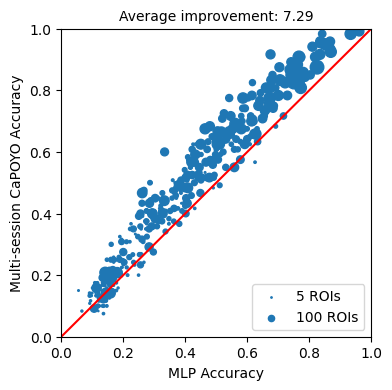

In [306]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.scatter(merged['best_test_acc'], merged['value'], s=merged["num_ROIs"] * 0.2)
plt.xlim([0., 1])
plt.ylim([0., 1])
# plot x = y
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('MLP Accuracy')
plt.ylabel('Multi-session CaPOYO Accuracy')
# make legend for smallest and biggest num_ROIs
plt.scatter([], [], s=5 * 0.2, c="tab:blue", label='5 ROIs')
plt.scatter([], [], s=100 * 0.2, c="tab:blue", label='100 ROIs')
# place legend on bottom right
plt.legend(loc='lower right')

plt.title(f"Average improvement: {(merged['value'].mean() - merged['best_test_acc'].mean()) * 100:.2f}", fontsize=10)

In [319]:
merged[merged["session_id"]== 510917254]

,session_id,run_count,best_val_acc,best_test_acc,metric,value,Session ID,old heldout,new heldout,Subject ID,Creline,Creline.1,depth,num_ROIs,num_timepoints,MLP_val_accuracy,MLP_test_accuracy
339,510917254,100,0.483333,0.254848,val_allen_brain_observatory_calcium/510917254_...,0.358333,510917254,False,False,234584,Rbp4-Cre_KL100,VISpm,375,61,56611,39.69697,22.5


In [222]:
df[df.run_count < 40]

,session_id,run_count,best_val_acc,best_test_acc
162,550851591,28,0.383333,0.232687
210,639932847,36,0.716667,0.716667
316,510517131,39,0.661111,0.627778


In [216]:
session_ids = ["501021421","501574836","501729039","501876401","501929610","501933264","501940850","502115959","502199136","502205092","502376461","502608215","502666254","502793808","502962794","503109347","503324629","503412730","504115289","504568756","504853580","505407318","505695962","505845219","506540916","506773185","506773892","506809539","506823562","507129766","507691036","507990552","508356957","508563988","508753256","509580400","509904120","509958730","510093797","510214538","510390912","510514474","510517131","510859641","510917254","511194579","511440894","511534603","511573879","511595995","512164988","512270518","512311673","512326618","524691284","526504941","527048992","528402271","529688779","530645663","531134090","539290504","539487468","539497234","540684467","541010698","541290571","545446482","546641574","546716391","547388708","548379748","550455111","550490398","550851591","551834174","551888519","552410386","552427971","552760671","553568031","554037270","555040116","555042467","555749369","556321897","556344224","556353209","556665481","557225279","557227804","557304694","557615965","557848210","558476282","558670888","559192380","559382012","560027980","560578599","560809202","560866155","560898462","560920977","560926639","561312435","561472633","562052595","562122508","562536153","562711440","563176332","563710064","564425777","564607188","565216523","565698388","566096665","566307038","566458505","567878987","569299884","569396924","569457162","569645690","569718097","569739027","569792817","569896493","570008444","570236381","570278597","570305847","571006300","571137446","571177441","571541565","571642389","571684733","572606382","572722662","573083539","573261515","573720508","573850303","574823092","575135986","575302108","575939366","575970700","576001843","576095926","576273468","576411246","577379202","577665023","578674360","580013262","580043440","580051759","580095647","580095655","580163817","581026088","581150104","581153070","581597734","582838758","582867147","582918858","583136567","583279803","584196534","584544569","584944065","584983136","585035184","585900296","587339481","587344053","588191926","588483711","588655112","589441079","589755795","590047029","590168385","591430494","591460070","591548033","592348507","592407200","592657427","593270603","593373156","593552712","594090967","594320795","595183197","595263154","595273803","595718342","595806300","595808594","596509886","596584192","596779487","597028938","598137246","598564173","598635821","599320182","599909878","601273921","601368107","601423209","601705404","601805379","601841437","601887677","601904502","601910964","602866800","603187982","603188560","603224878","603425659","603452291","603576132","603592541","603763073","603978471","604145810","604328043","604529230","605606109","605688822","605800963","605859367","605883133","606353987","606802468","607063420","609517556","609894681","611638995","611658482","612044635","612534310","612536911","612543999","612549085","613091721","613599811","613968705","614556106","614571626","616779893","617381605","617388117","617395455","623339221","623347352","623587006","626027944","627823636","627823695","637115675","637126541","637154333","637669270","637669284","637671554","637998955","638056634","638262558","638862121","639117196","639117826","639251932","639931541","639932847","640198011","642278925","642884591","643062797","643592303","643645390","644026238","644051974","644386884","644947716","645086975","645256361","645413759","645689073","646016204","647143225","647155122","647595665","647595671","647598519","647603932","649324898","649401936","649409874","649938038","650079244","651769499","651770186","651770380","651770794","652091264","652092676","652094901","652094917","652096183","652737678","652737867","652842495","652842572","652989442","653122667","653123929","653125130","653126877","653551965","653932505","654532828","657009581","657016267","657078119","657080632","657082055","657224241","657389972","657390171","657391037","657391625","657650110","657775947","657776356","657785850","657914280","657915168","658020691","658518486","658533763","658854537","659491419","660064796","660510593","660513003","661328410","661437140","662033243","662219852","662348804","662351164","662358771","662359728","662361096","662974315","662982346","663479824","663485329","663866413","663876406","664404274","664914611","665307545","665722301","665726618","667004159","669233895","669237515","669859475","669861524","670395725","670395999","670721589","670728674","671164733","671618887","672206735","672207947","672211004","673171528","673475020","673914981","674275260","674276329","674679019","675477919","676024666","676503588","679700458","679702884","680150733","680156911","682049099","682051855","683253712","683257169","685816006","686441799","686442556","686449092","686909240","688580172","688678766","689388034","691197571","692345003","692345336","696156783","698260532","698762886","699155265","701046700","702934964","703308071","704298735","707006626","707923645","710502981","710504563","710778377","712178483","712178511","712919665","715923832","716956096"]

# find session ids that are in the merged dataframe but not in the session_ids list
missing = set(session_ids) - set(df['session_id'].astype(str)) 
missing

{'501729039',
 '504115289',
 '512311673',
 '569457162',
 '570278597',
 '590047029',
 '604529230',
 '637115675',
 '639931541',
 '657650110',
 '669859475',
 '673914981',
 '703308071'}

In [274]:
df_capoyo_1 = pd.read_csv('wandb_export_2024-05-09T13_22_15.265-04_00.csv')
df_capoyo_2 = pd.read_csv('wandb_export_2024-05-15T15_41_42.966-04_00.csv')

In [275]:
# merge and rename value to value_1 and value_2 respectively
df_capoyo_merged = pd.merge(df_capoyo_1, df_capoyo_2, on='metric', how='inner', suffixes=('_1', '_2'))

In [281]:
df_capoyo_merged['session_id'] = df_capoyo_merged['metric'].apply(lambda x: x[36:36+9]).astype(int)
# merge with stats
df_capoyo_merged = pd.merge(df_capoyo_merged, df_stats, on='session_id', how='inner')

Text(0.5, 1.0, 'Average improvement: -1.87')

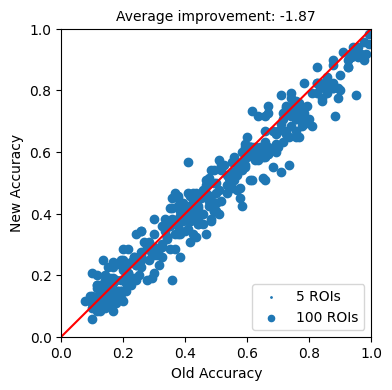

In [282]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.scatter(df_capoyo_merged['value_1'], df_capoyo_merged['value_2'],) # s=merged["num_ROIs"] * 0.2)
plt.xlim([0., 1])
plt.ylim([0., 1])
# plot x = y
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('Old Accuracy')
plt.ylabel('New Accuracy')
# make legend for smallest and biggest num_ROIs
plt.scatter([], [], s=5 * 0.2, c="tab:blue", label='5 ROIs')
plt.scatter([], [], s=100 * 0.2, c="tab:blue", label='100 ROIs')
# place legend on bottom right
plt.legend(loc='lower right')

plt.title(f"Average improvement: {(df_capoyo_merged['value_2'].mean() - df_capoyo_merged['value_1'].mean()) * 100:.2f}", fontsize=10)

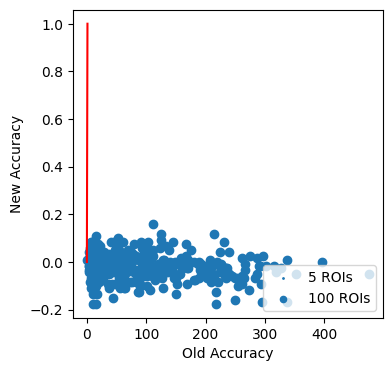

In [285]:
plt.figure(figsize=(4, 4))
plt.scatter(df_capoyo_merged['num_ROIs'], df_capoyo_merged['value_2'] - df_capoyo_merged["value_1"],) # s=merged["num_ROIs"] * 0.2)
# plot x = y
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('Old Accuracy')
plt.ylabel('New Accuracy')
# make legend for smallest and biggest num_ROIs
plt.scatter([], [], s=5 * 0.2, c="tab:blue", label='5 ROIs')
plt.scatter([], [], s=100 * 0.2, c="tab:blue", label='100 ROIs')
# place legend on bottom right
plt.legend(loc='lower right')


In [225]:
df[df.session_id == 698762886]

,session_id,run_count,best_val_acc,best_test_acc
401,698762886,240,0.805556,0.683333


Text(0, 0.5, 'Average accuracy over sessions')

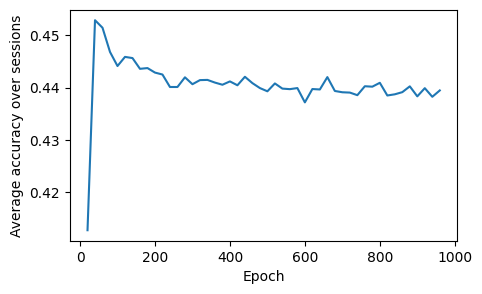

In [320]:

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

run_id = "neuro-galaxy/lightning_logs/sp03hpny"
#run_id = "neuro-galaxy/lightning_logs/3s47ycus"
# run_id = "neuro-galaxy/lightning_logs/8xezifn8"

api = wandb.Api()
run = api.run(run_id)

all_keys = list(run.summary.keys())
val_keys = [x for x in all_keys if x.startswith("val_allen")]

metrics = run.history(x_axis="epoch", keys=val_keys)
epoch_count = metrics["epoch"].to_numpy()
metrics = metrics.drop("epoch", axis=1)

plt.figure(figsize=(5,3))
plt.plot(epoch_count, metrics.mean(axis=1))
plt.xlabel("Epoch")
plt.ylabel("Average accuracy over sessions")

In [317]:
0.995 ** 100

0.6057704364907279